# Clustering Geoespacial-Delictivo de Municipios

## Descripcion del Modelo

Este notebook implementa un modelo de **clustering no supervisado** para agrupar municipios de Santander segun su comportamiento delictivo, demografico y geografico.

### Dataset
Combina las siguientes fuentes de datos:
- **Delitos agregados**: Total y por tipo de delito
- **Demografia**: Poblacion por grupos de edad y genero
- **Geografia**: Area, densidad poblacional, centros poblados
- **Indicadores poblacionales**: Proporciones demograficas

### Algoritmos Implementados
- **KMeans**: Clustering particional (modelo principal)
- **HDBSCAN**: Clustering basado en densidad (alternativo)

### Preguntas que Responde
1. Que municipios se parecen entre si en su comportamiento delictivo?
2. Que grupos presentan mayor concentracion de delitos?
3. Existen patrones urbano-rural en la criminalidad?

### Utilidad
- Crear grupos de municipios para politicas diferenciadas
- Identificar municipios con perfiles similares
- Generar mapas de clusters para visualizacion
- Inputs para chatbot y tablero de control

In [1]:
# =============================================================================
# CONFIGURACION E IMPORTACIONES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
import json
from datetime import datetime

# Sklearn - Preprocesamiento
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

# Sklearn - Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering

# Sklearn - Metricas
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# HDBSCAN
try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
except ImportError:
    HDBSCAN_AVAILABLE = False
    print("⚠️ HDBSCAN no instalado. Usar: pip install hdbscan")

warnings.filterwarnings('ignore')

# Configuracion de visualizacion
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
pd.set_option('display.max_columns', 50)

# Rutas
BASE_DIR = Path().resolve().parent
DATA_PATH = BASE_DIR / 'data' / 'gold' / 'model' / 'clustering_geo_dataset.parquet'
OUTPUT_DIR = BASE_DIR / 'models' / 'clustering' / 'geo_municipal'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Dataset:", DATA_PATH)
print("Output:", OUTPUT_DIR)

⚠️ HDBSCAN no instalado. Usar: pip install hdbscan
Dataset: /home/byverbel/challenges/Datos-al-Ecosistema/data/gold/model/clustering_geo_dataset.parquet
Output: /home/byverbel/challenges/Datos-al-Ecosistema/models/clustering/geo_municipal


In [2]:
# Cargar datos
df = pd.read_parquet(DATA_PATH)
print(f"Shape: {df.shape}")
print(f"\nColumnas: {df.columns.tolist()}")
df.head()

Shape: (12984, 45)

Columnas: ['codigo_departamento', 'municipio', 'area', 'codigo_municipio', 'departamento', 'Shape_Leng', 'Shape_Area', 'geometry', 'n_centros_poblados', 'anio', 'mes', 'total_delitos', 'ABIGEATO', 'AMENAZAS', 'DELITOS SEXUALES', 'EXTORSION', 'HOMICIDIOS', 'HURTOS', 'LESIONES', 'VIOLENCIA INTRAFAMILIAR', 'femenino_adolescentes', 'femenino_adultos', 'femenino_menores', 'masculino_adolescentes', 'masculino_adultos', 'masculino_menores', 'poblacion_total', 'poblacion_menores', 'poblacion_adultos', 'poblacion_adolescentes', 'area_km2', 'densidad_poblacional', 'centros_por_km2', 'proporcion_menores', 'proporcion_adultos', 'proporcion_adolescentes', 'fecha', 'trimestre', 'anio_mes', 'es_fin_ano', 'n_dias_semana', 'n_fines_de_semana', 'n_festivos', 'n_dias_laborales', 'cluster_delictivo']


,codigo_departamento,municipio,area,codigo_municipio,departamento,Shape_Leng,Shape_Area,geometry,n_centros_poblados,anio,mes,total_delitos,ABIGEATO,AMENAZAS,DELITOS SEXUALES,EXTORSION,HOMICIDIOS,HURTOS,LESIONES,VIOLENCIA INTRAFAMILIAR,femenino_adolescentes,femenino_adultos,femenino_menores,masculino_adolescentes,masculino_adultos,masculino_menores,poblacion_total,poblacion_menores,poblacion_adultos,poblacion_adolescentes,area_km2,densidad_poblacional,centros_por_km2,proporcion_menores,proporcion_adultos,proporcion_adolescentes,fecha,trimestre,anio_mes,es_fin_ano,n_dias_semana,n_fines_de_semana,n_festivos,n_dias_laborales,cluster_delictivo
0,68,AGUADA,75.231248,68013,SANTANDER,0.47581,0.006146,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1,2010,2,1,0,0,0,0,0,0,1,0,104,1455,289,123,1697,300,3968,589,3152,227,75.231248,52.744041,0.013292,0.148438,0.794355,0.057208,2010-02-01,1,2010-02,0,0,1,0,0,0
1,68,AGUADA,75.231248,68013,SANTANDER,0.47581,0.006146,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1,2011,1,3,0,1,0,0,0,0,2,0,103,1438,275,118,1672,290,3896,565,3110,221,75.231248,51.786992,0.013292,0.145021,0.798255,0.056725,2011-01-01,1,2011-01,0,0,2,0,0,0
2,68,AGUADA,75.231248,68013,SANTANDER,0.47581,0.006146,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1,2011,4,1,0,1,0,0,0,0,0,0,103,1438,275,118,1672,290,3896,565,3110,221,75.231248,51.786992,0.013292,0.145021,0.798255,0.056725,2011-04-01,2,2011-04,0,0,1,0,0,0
3,68,AGUADA,75.231248,68013,SANTANDER,0.47581,0.006146,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1,2011,5,1,0,1,0,0,0,0,0,0,103,1438,275,118,1672,290,3896,565,3110,221,75.231248,51.786992,0.013292,0.145021,0.798255,0.056725,2011-05-01,2,2011-05,0,1,0,0,1,0
4,68,AGUADA,75.231248,68013,SANTANDER,0.47581,0.006146,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1,2011,6,1,0,0,0,0,0,0,1,0,103,1438,275,118,1672,290,3896,565,3110,221,75.231248,51.786992,0.013292,0.145021,0.798255,0.056725,2011-06-01,2,2011-06,0,1,0,0,1,0


In [3]:
# 1.1 Cargar datos
df = pd.read_parquet(DATA_PATH)

print("=" * 70)
print("INFORMACION GENERAL DEL DATASET")
print("=" * 70)
print(f"\n> Shape: {df.shape[0]:,} registros x {df.shape[1]} columnas")
print(f"> Periodo: {df['anio'].min()} - {df['anio'].max()}")
print(f"> Municipios: {df['codigo_municipio'].nunique()}")
print(f"> Meses totales: {df['anio_mes'].nunique()}")

print("\nColumnas disponibles:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

df.head()

INFORMACION GENERAL DEL DATASET

> Shape: 12,984 registros x 45 columnas
> Periodo: 2010 - 2025
> Municipios: 87
> Meses totales: 190

Columnas disponibles:
    1. codigo_departamento
    2. municipio
    3. area
    4. codigo_municipio
    5. departamento
    6. Shape_Leng
    7. Shape_Area
    8. geometry
    9. n_centros_poblados
   10. anio
   11. mes
   12. total_delitos
   13. ABIGEATO
   14. AMENAZAS
   15. DELITOS SEXUALES
   16. EXTORSION
   17. HOMICIDIOS
   18. HURTOS
   19. LESIONES
   20. VIOLENCIA INTRAFAMILIAR
   21. femenino_adolescentes
   22. femenino_adultos
   23. femenino_menores
   24. masculino_adolescentes
   25. masculino_adultos
   26. masculino_menores
   27. poblacion_total
   28. poblacion_menores
   29. poblacion_adultos
   30. poblacion_adolescentes
   31. area_km2
   32. densidad_poblacional
   33. centros_por_km2
   34. proporcion_menores
   35. proporcion_adultos
   36. proporcion_adolescentes
   37. fecha
   38. trimestre
   39. anio_mes
   40. es_fin

,codigo_departamento,municipio,area,codigo_municipio,departamento,Shape_Leng,Shape_Area,geometry,n_centros_poblados,anio,mes,total_delitos,ABIGEATO,AMENAZAS,DELITOS SEXUALES,EXTORSION,HOMICIDIOS,HURTOS,LESIONES,VIOLENCIA INTRAFAMILIAR,femenino_adolescentes,femenino_adultos,femenino_menores,masculino_adolescentes,masculino_adultos,masculino_menores,poblacion_total,poblacion_menores,poblacion_adultos,poblacion_adolescentes,area_km2,densidad_poblacional,centros_por_km2,proporcion_menores,proporcion_adultos,proporcion_adolescentes,fecha,trimestre,anio_mes,es_fin_ano,n_dias_semana,n_fines_de_semana,n_festivos,n_dias_laborales,cluster_delictivo
0,68,AGUADA,75.231248,68013,SANTANDER,0.47581,0.006146,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1,2010,2,1,0,0,0,0,0,0,1,0,104,1455,289,123,1697,300,3968,589,3152,227,75.231248,52.744041,0.013292,0.148438,0.794355,0.057208,2010-02-01,1,2010-02,0,0,1,0,0,0
1,68,AGUADA,75.231248,68013,SANTANDER,0.47581,0.006146,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1,2011,1,3,0,1,0,0,0,0,2,0,103,1438,275,118,1672,290,3896,565,3110,221,75.231248,51.786992,0.013292,0.145021,0.798255,0.056725,2011-01-01,1,2011-01,0,0,2,0,0,0
2,68,AGUADA,75.231248,68013,SANTANDER,0.47581,0.006146,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1,2011,4,1,0,1,0,0,0,0,0,0,103,1438,275,118,1672,290,3896,565,3110,221,75.231248,51.786992,0.013292,0.145021,0.798255,0.056725,2011-04-01,2,2011-04,0,0,1,0,0,0
3,68,AGUADA,75.231248,68013,SANTANDER,0.47581,0.006146,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1,2011,5,1,0,1,0,0,0,0,0,0,103,1438,275,118,1672,290,3896,565,3110,221,75.231248,51.786992,0.013292,0.145021,0.798255,0.056725,2011-05-01,2,2011-05,0,1,0,0,1,0
4,68,AGUADA,75.231248,68013,SANTANDER,0.47581,0.006146,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1,2011,6,1,0,0,0,0,0,0,1,0,103,1438,275,118,1672,290,3896,565,3110,221,75.231248,51.786992,0.013292,0.145021,0.798255,0.056725,2011-06-01,2,2011-06,0,1,0,0,1,0


In [4]:
# 1.2 Tipos de datos y valores nulos
print("=" * 70)
print("TIPOS DE DATOS")
print("=" * 70)

print("\n> Dtypes:")
print(df.dtypes)

print("\n" + "=" * 70)
print("VALORES NULOS")
print("=" * 70)
null_counts = df.isnull().sum()
null_pct = (null_counts / len(df) * 100).round(2)
null_df = pd.DataFrame({'Nulos': null_counts, 'Porcentaje': null_pct})
null_df = null_df[null_df['Nulos'] > 0]

if len(null_df) > 0:
    print(null_df)
else:
    print("✅ No hay valores nulos en el dataset")

TIPOS DE DATOS

> Dtypes:
codigo_departamento                object
municipio                          object
area                              float64
codigo_municipio                    Int64
departamento                       object
Shape_Leng                        float64
Shape_Area                        float64
geometry                           object
n_centros_poblados                  int64
anio                                Int64
mes                                 Int64
total_delitos                       int64
ABIGEATO                            int64
AMENAZAS                            int64
DELITOS SEXUALES                    int64
EXTORSION                           int64
HOMICIDIOS                          int64
HURTOS                              int64
LESIONES                            int64
VIOLENCIA INTRAFAMILIAR             int64
femenino_adolescentes               int64
femenino_adultos                    int64
femenino_menores                    int64
masculin

In [5]:
# 1.3 Estadisticas descriptivas
print("=" * 70)
print("ESTADISTICAS DESCRIPTIVAS")
print("=" * 70)

# Seleccionar columnas numericas relevantes
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Excluir codigos y anios
exclude = ['codigo_departamento', 'codigo_municipio', 'anio', 'mes', 'trimestre', 'cluster_delictivo']
numeric_cols = [c for c in numeric_cols if c not in exclude]

print(f"\n> Variables numericas: {len(numeric_cols)}")
df[numeric_cols].describe().T

ESTADISTICAS DESCRIPTIVAS

> Variables numericas: 34


,count,mean,std,min,25%,50%,75%,max
area,12984.0,398.980973,483.428531,19.694442,97.606913,258.946152,483.970127,3.174289e+03
Shape_Leng,12984.0,1.128034,0.860523,0.270018,0.529697,0.882292,1.318415,4.357081e+00
Shape_Area,12984.0,0.032628,0.039542,0.001610,0.007981,0.021162,0.039550,2.594592e-01
n_centros_poblados,12984.0,4.588185,4.070179,1.000000,2.000000,4.000000,6.000000,2.300000e+01
total_delitos,12984.0,37.138016,135.662311,1.000000,2.000000,4.000000,12.000000,1.769000e+03
ABIGEATO,12984.0,0.100662,0.428104,0.000000,0.000000,0.000000,0.000000,1.200000e+01
AMENAZAS,12984.0,3.220117,11.548587,0.000000,0.000000,0.000000,2.000000,1.920000e+02
DELITOS SEXUALES,12984.0,1.808457,5.348997,0.000000,0.000000,0.000000,1.000000,7.800000e+01
EXTORSION,12984.0,0.230206,1.117971,0.000000,0.000000,0.000000,0.000000,3.400000e+01
HOMICIDIOS,12984.0,0.764710,2.580271,0.000000,0.000000,0.000000,0.000000,4.700000e+01


DISTRIBUCION DE CLUSTERS EXISTENTES

> Distribucion de clusters en el dataset:
cluster_delictivo
0    12034
1      190
2      664
3       96
Name: count, dtype: int64

> Total de clusters unicos: 4


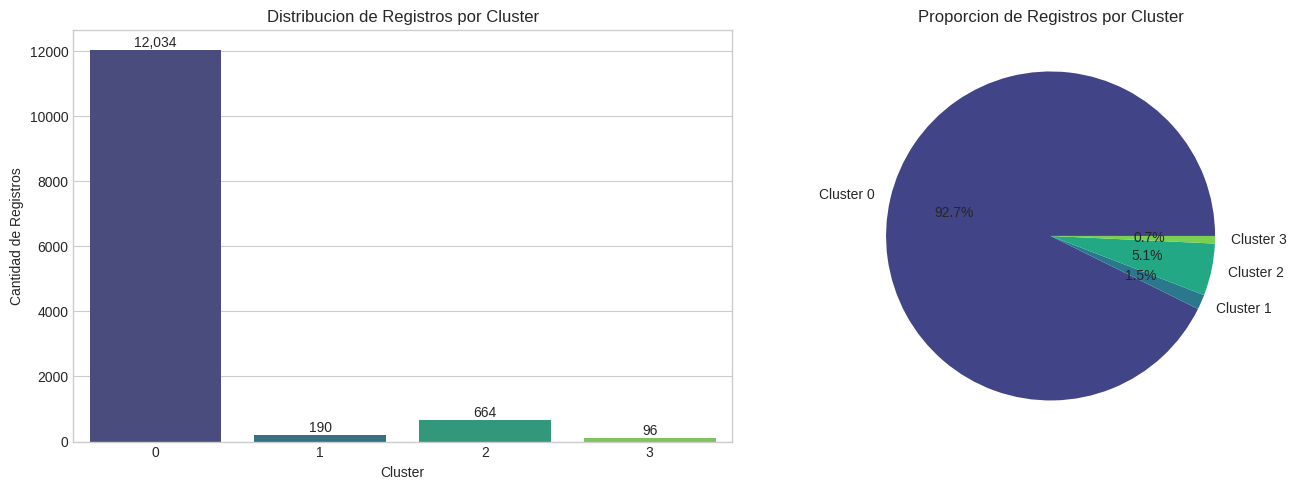

In [6]:
# 1.4 Distribucion de clusters existentes
print("=" * 70)
print("DISTRIBUCION DE CLUSTERS EXISTENTES")
print("=" * 70)

cluster_dist = df['cluster_delictivo'].value_counts().sort_index()
print("\n> Distribucion de clusters en el dataset:")
print(cluster_dist)
print(f"\n> Total de clusters unicos: {df['cluster_delictivo'].nunique()}")

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Barplot
sns.barplot(x=cluster_dist.index, y=cluster_dist.values, ax=axes[0], palette='viridis')
axes[0].set_title('Distribucion de Registros por Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Cantidad de Registros')
for i, v in enumerate(cluster_dist.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontsize=10)

# Pie chart
axes[1].pie(cluster_dist.values, labels=[f'Cluster {i}' for i in cluster_dist.index],
            autopct='%1.1f%%', colors=sns.color_palette('viridis', len(cluster_dist)))
axes[1].set_title('Proporcion de Registros por Cluster')

plt.tight_layout()
plt.show()

---
## 2. Analisis Exploratorio de Datos (EDA)

In [7]:
# 2.1 Definir categorias de variables
print("=" * 70)
print("CATEGORIZACION DE VARIABLES PARA CLUSTERING")
print("=" * 70)

# Variables de delitos
DELITOS_COLS = ['ABIGEATO', 'AMENAZAS', 'DELITOS SEXUALES', 'EXTORSION', 
                'HOMICIDIOS', 'HURTOS', 'LESIONES', 'VIOLENCIA INTRAFAMILIAR', 'total_delitos']

# Variables demograficas
DEMO_COLS = ['poblacion_total', 'poblacion_menores', 'poblacion_adultos', 
             'poblacion_adolescentes', 'femenino_adolescentes', 'femenino_adultos',
             'femenino_menores', 'masculino_adolescentes', 'masculino_adultos', 'masculino_menores']

# Variables geograficas
GEO_COLS = ['area_km2', 'densidad_poblacional', 'n_centros_poblados', 'centros_por_km2']

# Variables de proporciones poblacionales
PROP_COLS = ['proporcion_menores', 'proporcion_adultos', 'proporcion_adolescentes']

# Variables temporales (para analisis pero NO para clustering)
TEMPORAL_COLS = ['anio', 'mes', 'trimestre', 'es_fin_ano', 
                 'n_dias_semana', 'n_fines_de_semana', 'n_festivos', 'n_dias_laborales']

# Variables identificadoras (NO para clustering)
ID_COLS = ['codigo_departamento', 'departamento', 'codigo_municipio', 'municipio', 
           'geometry', 'Shape_Leng', 'Shape_Area', 'area', 'fecha', 'anio_mes']

print("\n> Variables de Delitos:", len(DELITOS_COLS))
print("> Variables Demograficas:", len(DEMO_COLS))
print("> Variables Geograficas:", len(GEO_COLS))
print("> Variables de Proporciones:", len(PROP_COLS))
print("> Variables Temporales:", len(TEMPORAL_COLS))
print("> Variables ID (excluidas):", len(ID_COLS))

CATEGORIZACION DE VARIABLES PARA CLUSTERING

> Variables de Delitos: 9
> Variables Demograficas: 10
> Variables Geograficas: 4
> Variables de Proporciones: 3
> Variables Temporales: 8
> Variables ID (excluidas): 10


DISTRIBUCION DE VARIABLES DE DELITOS


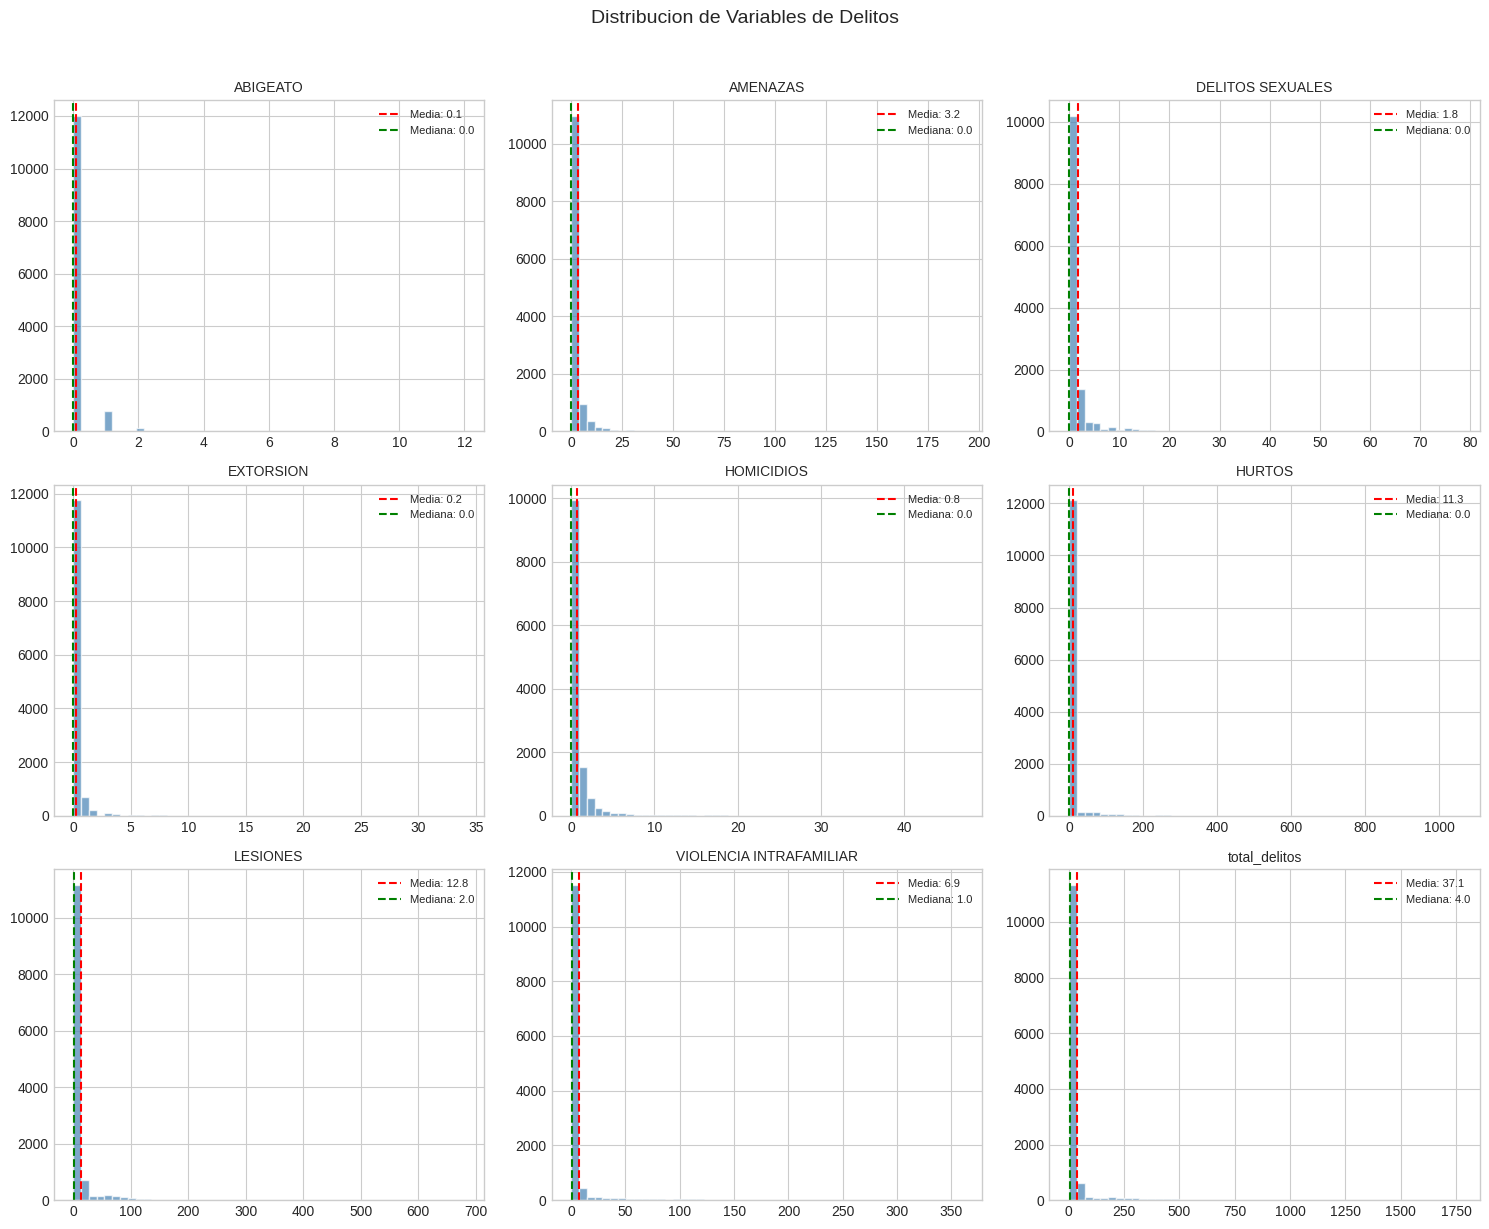


⚠️ NOTA: Las distribuciones son muy sesgadas (muchos ceros). Considerar transformaciones.


In [8]:
# 2.2 Distribucion de variables de delitos
print("=" * 70)
print("DISTRIBUCION DE VARIABLES DE DELITOS")
print("=" * 70)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(DELITOS_COLS):
    ax = axes[i]
    df[col].hist(ax=ax, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
    ax.set_title(f'{col}', fontsize=10)
    ax.set_xlabel('')
    
    # Estadisticas
    mean_val = df[col].mean()
    median_val = df[col].median()
    ax.axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.1f}')
    ax.axvline(median_val, color='green', linestyle='--', label=f'Mediana: {median_val:.1f}')
    ax.legend(fontsize=8)

plt.suptitle('Distribucion de Variables de Delitos', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n⚠️ NOTA: Las distribuciones son muy sesgadas (muchos ceros). Considerar transformaciones.")

DISTRIBUCION DE VARIABLES GEOGRAFICAS Y DEMOGRAFICAS


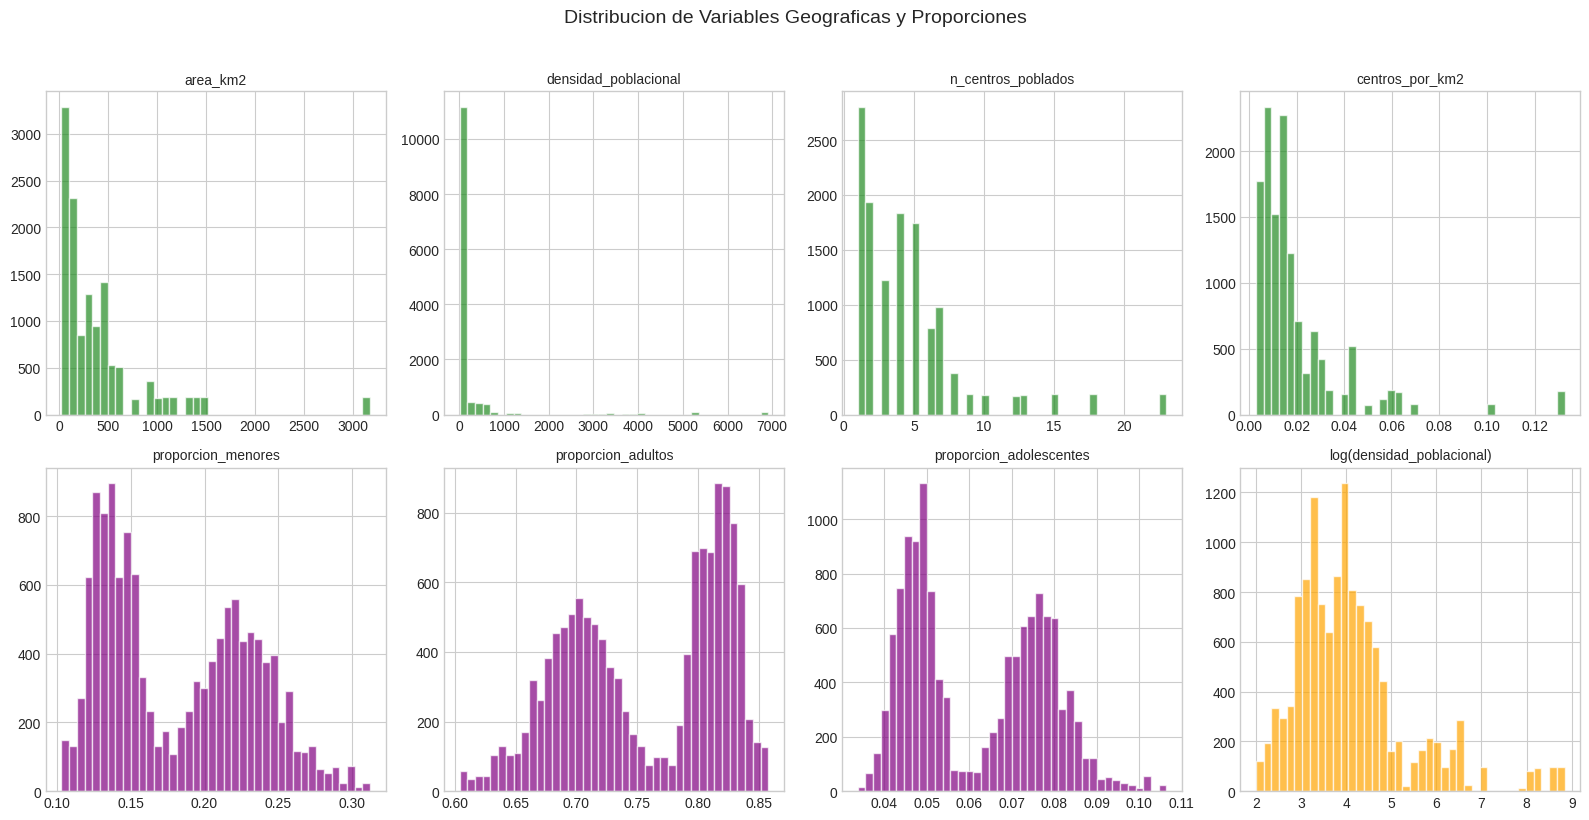

In [9]:
# 2.3 Distribucion de variables geograficas y demograficas
print("=" * 70)
print("DISTRIBUCION DE VARIABLES GEOGRAFICAS Y DEMOGRAFICAS")
print("=" * 70)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Variables geograficas
for i, col in enumerate(GEO_COLS):
    ax = axes[0, i]
    df[col].hist(ax=ax, bins=40, color='forestgreen', edgecolor='white', alpha=0.7)
    ax.set_title(f'{col}', fontsize=10)

# Proporciones poblacionales
for i, col in enumerate(PROP_COLS):
    ax = axes[1, i]
    df[col].hist(ax=ax, bins=40, color='purple', edgecolor='white', alpha=0.7)
    ax.set_title(f'{col}', fontsize=10)

# Densidad poblacional (log)
ax = axes[1, 3]
np.log1p(df['densidad_poblacional']).hist(ax=ax, bins=40, color='orange', edgecolor='white', alpha=0.7)
ax.set_title('log(densidad_poblacional)', fontsize=10)

plt.suptitle('Distribucion de Variables Geograficas y Proporciones', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

 MATRIZ DE CORRELACIÓN


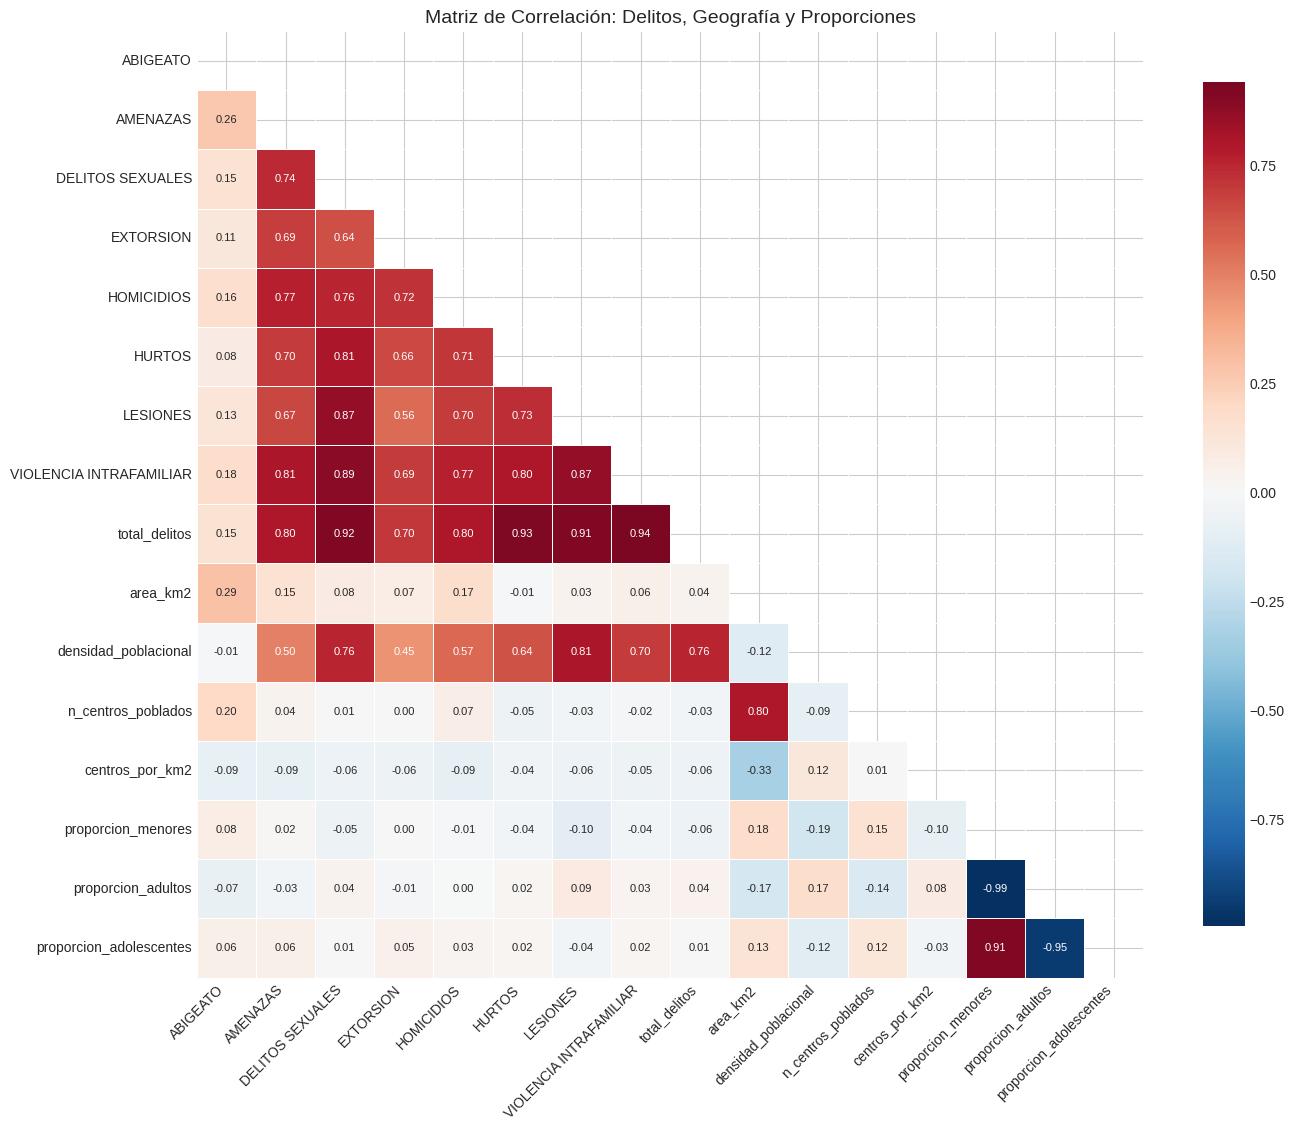


 Correlaciones más altas (>0.7):


In [10]:
# 2.4 Correlación entre variables
print("=" * 70)
print(" MATRIZ DE CORRELACIÓN")
print("=" * 70)

# Seleccionar variables para correlación
corr_cols = DELITOS_COLS + GEO_COLS + PROP_COLS
corr_matrix = df[corr_cols].corr()

# Heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5, cbar_kws={'shrink': 0.8},
            annot_kws={'size': 8})
plt.title('Matriz de Correlación: Delitos, Geografía y Proporciones', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Correlaciones más altas
print("\n Correlaciones más altas (>0.7):")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'Var1': corr_matrix.columns[i],
                'Var2': corr_matrix.columns[j],
                'Correlación': corr_matrix.iloc[i, j]
            })

if high_corr:
    pd.DataFrame(high_corr).sort_values('Correlación', ascending=False)
else:
    print("   No hay correlaciones > 0.7")

In [11]:
# 2.5 Análisis de delitos por municipio (agregado)
print("=" * 70)
print(" ANÁLISIS DE DELITOS AGREGADOS POR MUNICIPIO")
print("=" * 70)

# Agregar por municipio
df_mun = df.groupby(['codigo_municipio', 'municipio']).agg({
    'total_delitos': 'sum',
    'poblacion_total': 'mean',
    'area_km2': 'first',
    'densidad_poblacional': 'mean',
    'n_centros_poblados': 'first',
    **{col: 'sum' for col in DELITOS_COLS if col != 'total_delitos'}
}).reset_index()

# Tasa de delitos por 100k habitantes
df_mun['tasa_delitos_100k'] = (df_mun['total_delitos'] / df_mun['poblacion_total']) * 100000

print(f"\n Municipios únicos: {len(df_mun)}")
print(f"\n Top 10 municipios con más delitos:")
print(df_mun.nlargest(10, 'total_delitos')[['municipio', 'total_delitos', 'poblacion_total', 'tasa_delitos_100k']])

print(f"\n Top 10 municipios con mayor TASA de delitos (por 100k hab):")
print(df_mun.nlargest(10, 'tasa_delitos_100k')[['municipio', 'total_delitos', 'poblacion_total', 'tasa_delitos_100k']])

 ANÁLISIS DE DELITOS AGREGADOS POR MUNICIPIO

 Municipios únicos: 87

 Top 10 municipios con más delitos:
           municipio  total_delitos  poblacion_total  tasa_delitos_100k
0        BUCARAMANGA         183490    832057.126316       22052.572377
6    BARRANCABERMEJA          65038    298330.652632       21800.642819
32     FLORIDABLANCA          53005    426773.673684       12419.931985
35             GIRÓN          39282    259669.357895       15127.699440
60       PIEDECUESTA          33644    237405.410526       14171.538856
69           SAN GIL          11528     75852.400000       15197.937046
4            BARBOSA           9090     44577.484211       20391.460310
66  SABANA DE TORRES           7418     35992.642105       20609.767903
19         CIMITARRA           6780     60730.957895       11163.993184
47           LEBRIJA           6632     59824.915789       11085.682132

 Top 10 municipios con mayor TASA de delitos (por 100k hab):
           municipio  total_delitos  pob

 ANÁLISIS PATRÓN URBANO-RURAL


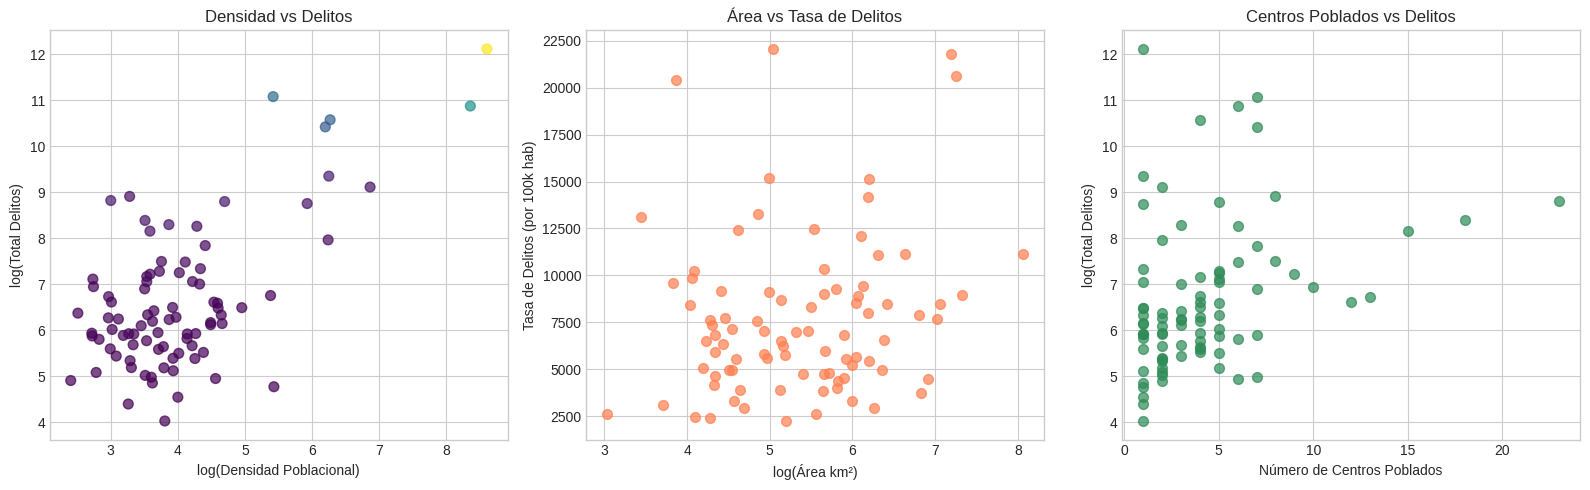


 Clasificación Urbano/Rural (umbral densidad: 43.4 hab/km²):
tipo_zona
Urbano    44
Rural     43
Name: count, dtype: int64

 Promedio de delitos por tipo de zona:
tipo_zona
Rural     1011.976744
Urbano    9970.113636
Name: total_delitos, dtype: float64


In [12]:
# 2.6 Visualización: Patrón Urbano-Rural
print("=" * 70)
print(" ANÁLISIS PATRÓN URBANO-RURAL")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Densidad vs Total Delitos
ax1 = axes[0]
ax1.scatter(np.log1p(df_mun['densidad_poblacional']), 
            np.log1p(df_mun['total_delitos']), 
            c=df_mun['poblacion_total'], cmap='viridis', alpha=0.7, s=50)
ax1.set_xlabel('log(Densidad Poblacional)')
ax1.set_ylabel('log(Total Delitos)')
ax1.set_title('Densidad vs Delitos')

# 2. Área vs Tasa de Delitos
ax2 = axes[1]
ax2.scatter(np.log1p(df_mun['area_km2']), 
            df_mun['tasa_delitos_100k'], 
            c='coral', alpha=0.7, s=50)
ax2.set_xlabel('log(Área km²)')
ax2.set_ylabel('Tasa de Delitos (por 100k hab)')
ax2.set_title('Área vs Tasa de Delitos')

# 3. Centros Poblados vs Delitos
ax3 = axes[2]
ax3.scatter(df_mun['n_centros_poblados'], 
            np.log1p(df_mun['total_delitos']), 
            c='seagreen', alpha=0.7, s=50)
ax3.set_xlabel('Número de Centros Poblados')
ax3.set_ylabel('log(Total Delitos)')
ax3.set_title('Centros Poblados vs Delitos')

plt.tight_layout()
plt.show()

# Clasificación simple urbano/rural
umbral_densidad = df_mun['densidad_poblacional'].median()
df_mun['tipo_zona'] = np.where(df_mun['densidad_poblacional'] >= umbral_densidad, 'Urbano', 'Rural')

print(f"\n Clasificación Urbano/Rural (umbral densidad: {umbral_densidad:.1f} hab/km²):")
print(df_mun['tipo_zona'].value_counts())

print(f"\n Promedio de delitos por tipo de zona:")
print(df_mun.groupby('tipo_zona')['total_delitos'].mean())

---
## 3. Preprocesamiento de Datos para Clustering

In [13]:
# 3.1 Crear dataset agregado por municipio para clustering
print("=" * 70)
print(" CREACIÓN DE DATASET AGREGADO PARA CLUSTERING")
print("=" * 70)

# Para clustering, agregamos por municipio usando la información más reciente
# y promedios/sumas según corresponda

# Delitos: suma total por municipio
delitos_agg = df.groupby('codigo_municipio')[DELITOS_COLS].sum()

# Demografía: promedio (cambia poco en el tiempo)
demo_agg = df.groupby('codigo_municipio')[DEMO_COLS].mean()

# Geografía: primer valor (no cambia)
geo_agg = df.groupby('codigo_municipio')[GEO_COLS].first()

# Proporciones: promedio
prop_agg = df.groupby('codigo_municipio')[PROP_COLS].mean()

# Unir todo
df_cluster = pd.concat([delitos_agg, demo_agg, geo_agg, prop_agg], axis=1).reset_index()

# Agregar nombre del municipio
mun_names = df[['codigo_municipio', 'municipio']].drop_duplicates()
df_cluster = df_cluster.merge(mun_names, on='codigo_municipio', how='left')

print(f"\n Dataset de clustering creado:")
print(f"   - Municipios: {len(df_cluster)}")
print(f"   - Variables: {df_cluster.shape[1]}")

df_cluster.head()

 CREACIÓN DE DATASET AGREGADO PARA CLUSTERING

 Dataset de clustering creado:
   - Municipios: 87
   - Variables: 28


,codigo_municipio,ABIGEATO,AMENAZAS,DELITOS SEXUALES,EXTORSION,HOMICIDIOS,HURTOS,LESIONES,VIOLENCIA INTRAFAMILIAR,total_delitos,poblacion_total,poblacion_menores,poblacion_adultos,poblacion_adolescentes,femenino_adolescentes,femenino_adultos,femenino_menores,masculino_adolescentes,masculino_adultos,masculino_menores,area_km2,densidad_poblacional,n_centros_poblados,centros_por_km2,proporcion_menores,proporcion_adultos,proporcion_adolescentes,municipio
0,68001,14,11343,6691,987,2733,73088,59473,29161,183490,832057.126316,114399.421053,673205.284211,44452.421053,21898.810526,356110.178947,56000.021053,22553.610526,317095.105263,58399.400000,152.915686,6853.842316,1,0.006540,0.147852,0.794527,0.057621,BUCARAMANGA
1,68013,1,26,21,2,1,8,45,23,127,2738.541667,422.958333,2157.222222,158.361111,76.291667,1020.666667,200.194444,82.069444,1136.555556,222.763889,75.231248,52.744041,1,0.013292,0.160829,0.778188,0.060983,AGUADA
2,68020,10,57,28,4,14,42,61,65,281,7159.309524,1182.611111,5581.619048,395.079365,181.484127,2618.317460,562.968254,213.595238,2963.301587,619.642857,166.216966,57.430960,4,0.024065,0.174865,0.767074,0.058061,ALBANIA
3,68051,4,79,65,3,44,113,651,142,1101,12657.221622,2070.702703,9833.054054,753.464865,344.751351,4647.367568,995.735135,408.713514,5185.686486,1074.967568,169.791552,98.450128,3,0.017669,0.177208,0.758143,0.064648,ARATOCA
4,68077,28,951,377,52,158,1966,4081,1477,9090,44577.484211,7348.168421,34661.663158,2567.652632,1251.452632,18119.957895,3518.768421,1316.200000,16541.705263,3829.400000,46.664887,1173.130453,2,0.042859,0.176776,0.760912,0.062312,BARBOSA


In [14]:
# 3.2 Crear variables derivadas
print("=" * 70)
print(" CREACIÓN DE VARIABLES DERIVADAS")
print("=" * 70)

# Tasas por 100k habitantes
for col in DELITOS_COLS:
    df_cluster[f'{col}_tasa'] = (df_cluster[col] / df_cluster['poblacion_total']) * 100000

# Log-transformaciones para variables muy sesgadas
df_cluster['log_poblacion'] = np.log1p(df_cluster['poblacion_total'])
df_cluster['log_densidad'] = np.log1p(df_cluster['densidad_poblacional'])
df_cluster['log_area'] = np.log1p(df_cluster['area_km2'])
df_cluster['log_total_delitos'] = np.log1p(df_cluster['total_delitos'])

# Ratio delitos/área
df_cluster['delitos_por_km2'] = df_cluster['total_delitos'] / df_cluster['area_km2']

# Proporción de cada tipo de delito
for col in DELITOS_COLS:
    if col != 'total_delitos':
        df_cluster[f'{col}_prop'] = df_cluster[col] / df_cluster['total_delitos'].replace(0, 1)

print(f"\n Variables totales después de derivaciones: {df_cluster.shape[1]}")
print(f"\n Nuevas variables creadas:")
print("   - Tasas por 100k habitantes")
print("   - Log-transformaciones")
print("   - Delitos por km²")
print("   - Proporciones de cada delito")

df_cluster.head()

 CREACIÓN DE VARIABLES DERIVADAS

 Variables totales después de derivaciones: 50

 Nuevas variables creadas:
   - Tasas por 100k habitantes
   - Log-transformaciones
   - Delitos por km²
   - Proporciones de cada delito


,codigo_municipio,ABIGEATO,AMENAZAS,DELITOS SEXUALES,EXTORSION,HOMICIDIOS,HURTOS,LESIONES,VIOLENCIA INTRAFAMILIAR,total_delitos,poblacion_total,poblacion_menores,poblacion_adultos,poblacion_adolescentes,femenino_adolescentes,femenino_adultos,femenino_menores,masculino_adolescentes,masculino_adultos,masculino_menores,area_km2,densidad_poblacional,n_centros_poblados,centros_por_km2,proporcion_menores,proporcion_adultos,proporcion_adolescentes,municipio,ABIGEATO_tasa,AMENAZAS_tasa,DELITOS SEXUALES_tasa,EXTORSION_tasa,HOMICIDIOS_tasa,HURTOS_tasa,LESIONES_tasa,VIOLENCIA INTRAFAMILIAR_tasa,total_delitos_tasa,log_poblacion,log_densidad,log_area,log_total_delitos,delitos_por_km2,ABIGEATO_prop,AMENAZAS_prop,DELITOS SEXUALES_prop,EXTORSION_prop,HOMICIDIOS_prop,HURTOS_prop,LESIONES_prop,VIOLENCIA INTRAFAMILIAR_prop
0,68001,14,11343,6691,987,2733,73088,59473,29161,183490,832057.126316,114399.421053,673205.284211,44452.421053,21898.810526,356110.178947,56000.021053,22553.610526,317095.105263,58399.400000,152.915686,6853.842316,1,0.006540,0.147852,0.794527,0.057621,BUCARAMANGA,1.682577,1363.247744,804.151517,118.621663,328.463024,8784.012262,7147.706344,3504.687248,22052.572377,13.631658,8.832711,5.036405,12.119921,1199.942300,0.000076,0.061818,0.036465,0.005379,0.014895,0.398321,0.324121,0.158924
1,68013,1,26,21,2,1,8,45,23,127,2738.541667,422.958333,2157.222222,158.361111,76.291667,1020.666667,200.194444,82.069444,1136.555556,222.763889,75.231248,52.744041,1,0.013292,0.160829,0.778188,0.060983,AGUADA,36.515785,949.410422,766.831495,73.031571,36.515785,292.126284,1643.210346,839.863066,4637.504755,7.915546,3.984233,4.333771,4.852030,1.688128,0.007874,0.204724,0.165354,0.015748,0.007874,0.062992,0.354331,0.181102
2,68020,10,57,28,4,14,42,61,65,281,7159.309524,1182.611111,5581.619048,395.079365,181.484127,2618.317460,562.968254,213.595238,2963.301587,619.642857,166.216966,57.430960,4,0.024065,0.174865,0.767074,0.058061,ALBANIA,139.678274,796.166164,391.099168,55.871310,195.549584,586.648752,852.037474,907.908783,3924.959510,8.876308,4.067846,5.119292,5.641907,1.690561,0.035587,0.202847,0.099644,0.014235,0.049822,0.149466,0.217082,0.231317
3,68051,4,79,65,3,44,113,651,142,1101,12657.221622,2070.702703,9833.054054,753.464865,344.751351,4647.367568,995.735135,408.713514,5185.686486,1074.967568,169.791552,98.450128,3,0.017669,0.177208,0.758143,0.064648,ARATOCA,31.602512,624.149615,513.540822,23.701884,347.627634,892.770968,5143.308851,1121.889181,8698.591467,9.446062,4.599656,5.140444,7.004882,6.484422,0.003633,0.071753,0.059037,0.002725,0.039964,0.102634,0.591281,0.128974
4,68077,28,951,377,52,158,1966,4081,1477,9090,44577.484211,7348.168421,34661.663158,2567.652632,1251.452632,18119.957895,3518.768421,1316.200000,16541.705263,3829.400000,46.664887,1173.130453,2,0.042859,0.176776,0.760912,0.062312,BARBOSA,62.811979,2133.363999,845.718431,116.650818,354.439024,4410.298236,9154.845932,3313.331890,20391.460310,10.705007,7.068283,3.864195,9.115040,194.793143,0.003080,0.104620,0.041474,0.005721,0.017382,0.216282,0.448955,0.162486


In [15]:
# 3.3 Seleccionar features para clustering
print("=" * 70)
print(" SELECCIÓN DE FEATURES PARA CLUSTERING")
print("=" * 70)

# Opción 1: Usar tasas (normalizado por población) + geografía
FEATURE_OPTION_1 = [
    # Tasas de delitos
    'total_delitos_tasa', 'HURTOS_tasa', 'LESIONES_tasa', 
    'VIOLENCIA INTRAFAMILIAR_tasa', 'HOMICIDIOS_tasa', 'AMENAZAS_tasa',
    # Geografía
    'log_densidad', 'log_area', 'centros_por_km2',
    # Proporciones poblacionales
    'proporcion_menores', 'proporcion_adultos', 'proporcion_adolescentes'
]

# Opción 2: Usar proporciones de delitos + geografía (enfoque composicional)
FEATURE_OPTION_2 = [
    # Proporciones de delitos
    'HURTOS_prop', 'LESIONES_prop', 'VIOLENCIA INTRAFAMILIAR_prop',
    'HOMICIDIOS_prop', 'AMENAZAS_prop', 'DELITOS SEXUALES_prop',
    # Geografía
    'log_densidad', 'log_area', 'centros_por_km2',
    # Volumen
    'log_total_delitos', 'log_poblacion'
]

# Usaremos Opción 1 como principal (más interpretable)
FEATURE_COLS = FEATURE_OPTION_1

# Verificar que todas las columnas existen
missing_cols = [c for c in FEATURE_COLS if c not in df_cluster.columns]
if missing_cols:
    print(f"⚠️ Columnas faltantes: {missing_cols}")
else:
    print("✅ Todas las columnas están disponibles")

print(f"\n🔹 Features seleccionadas ({len(FEATURE_COLS)}):")
for i, col in enumerate(FEATURE_COLS, 1):
    print(f"   {i:2d}. {col}")

# Crear matriz X
X = df_cluster[FEATURE_COLS].copy()

# Verificar nulos
print(f"\n Valores nulos en X:")
print(X.isnull().sum().sum())

 SELECCIÓN DE FEATURES PARA CLUSTERING
✅ Todas las columnas están disponibles

🔹 Features seleccionadas (12):
    1. total_delitos_tasa
    2. HURTOS_tasa
    3. LESIONES_tasa
    4. VIOLENCIA INTRAFAMILIAR_tasa
    5. HOMICIDIOS_tasa
    6. AMENAZAS_tasa
    7. log_densidad
    8. log_area
    9. centros_por_km2
   10. proporcion_menores
   11. proporcion_adultos
   12. proporcion_adolescentes

 Valores nulos en X:
0


In [16]:
# 3.4 Manejar valores infinitos y nulos
print("=" * 70)
print(" MANEJO DE VALORES INFINITOS Y NULOS")
print("=" * 70)

# Reemplazar infinitos por NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Verificar e imputar nulos
null_counts = X.isnull().sum()
if null_counts.sum() > 0:
    print("⚠️ Valores nulos encontrados:")
    print(null_counts[null_counts > 0])
    
    # Imputar con la mediana
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].median())
    print("\n✅ Nulos imputados con la mediana")
else:
    print("✅ No hay valores nulos")

print(f"\n Shape de X: {X.shape}")

 MANEJO DE VALORES INFINITOS Y NULOS
✅ No hay valores nulos

 Shape de X: (87, 12)


In [17]:
# 3.5 Escalar los datos
print("=" * 70)
print(" ESCALADO DE DATOS")
print("=" * 70)

# Usar RobustScaler (más resistente a outliers que StandardScaler)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Convertir a DataFrame para visualización
X_scaled_df = pd.DataFrame(X_scaled, columns=FEATURE_COLS, index=df_cluster['codigo_municipio'])

print(f"\n Datos escalados con RobustScaler")
print(f" Shape: {X_scaled.shape}")

# Estadísticas post-escalado
print("\n Estadísticas post-escalado:")
print(pd.DataFrame(X_scaled, columns=FEATURE_COLS).describe().T[['mean', 'std', 'min', 'max']])

 ESCALADO DE DATOS

 Datos escalados con RobustScaler
 Shape: (87, 12)

 Estadísticas post-escalado:
                                  mean       std       min       max
total_delitos_tasa            0.192122  0.978186 -1.056061  3.487690
HURTOS_tasa                   0.532703  1.584759 -0.785479  9.303211
LESIONES_tasa                 0.243376  0.761066 -0.741476  2.883427
VIOLENCIA INTRAFAMILIAR_tasa  0.148339  0.811725 -1.181398  3.538312
HOMICIDIOS_tasa               0.166897  0.913900 -0.939364  3.892573
AMENAZAS_tasa                 0.143948  0.907256 -1.053419  3.793577
log_densidad                  0.242185  1.089634 -1.399386  4.657712
log_area                      0.022837  0.657544 -1.486322  1.791956
centros_por_km2               0.441105  1.371100 -0.733771  7.867326
proporcion_menores            0.077893  0.743828 -1.326144  2.682036
proporcion_adultos           -0.139530  0.812595 -2.870504  1.354232
proporcion_adolescentes       0.035748  0.829427 -1.557325  3.190306


 PCA PARA VISUALIZACIÓN

 Varianza explicada:
   PC1: 44.50%
   PC2: 25.47%
   Total: 69.97%


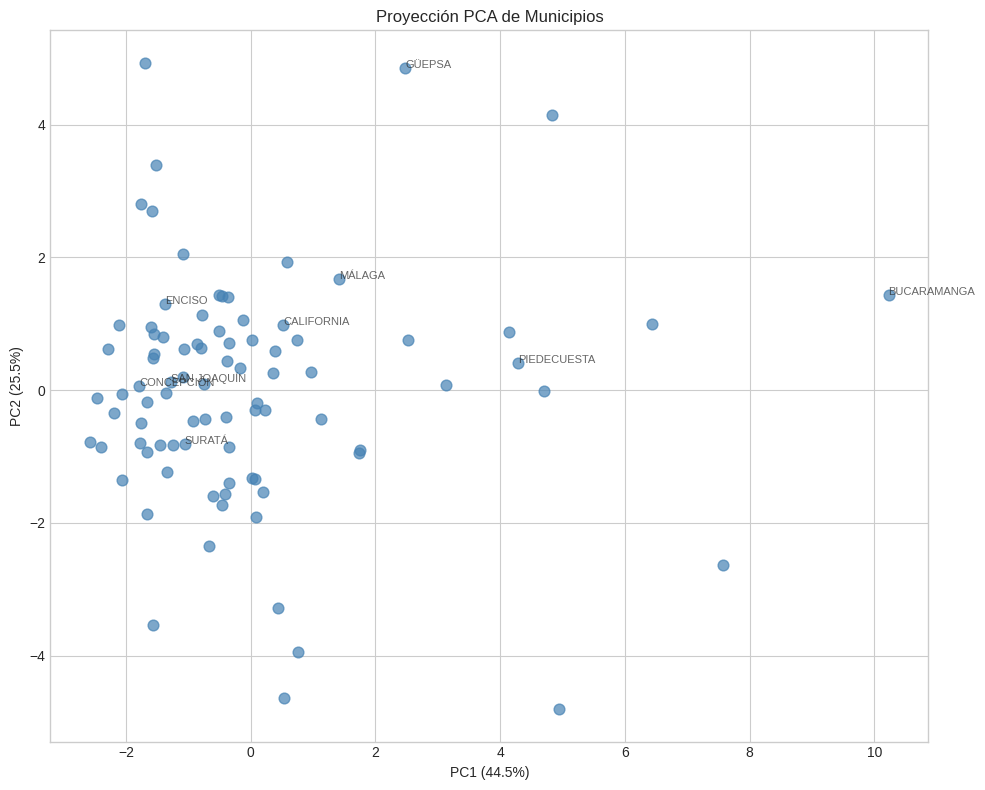


 Contribución de variables a cada PC:
                                   PC1       PC2
HURTOS_tasa                   0.670358 -0.003383
total_delitos_tasa            0.411368 -0.100864
log_densidad                  0.352326  0.331856
VIOLENCIA INTRAFAMILIAR_tasa  0.288449 -0.022007
LESIONES_tasa                 0.288120 -0.054340
AMENAZAS_tasa                 0.221820 -0.226833
HOMICIDIOS_tasa               0.180719 -0.327582
proporcion_adultos            0.061277  0.370276
centros_por_km2               0.032148  0.557095
log_area                      0.020326 -0.298751
proporcion_adolescentes      -0.012199 -0.264582
proporcion_menores           -0.061908 -0.332824


In [18]:
# 3.6 Reducción de dimensionalidad con PCA (para visualización)
print("=" * 70)
print(" PCA PARA VISUALIZACIÓN")
print("=" * 70)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"\n Varianza explicada:")
print(f"   PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"   PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"   Total: {sum(pca.explained_variance_ratio_):.2%}")

# Visualizar los datos en 2D
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='steelblue', alpha=0.7, s=60)

# Anotar algunos municipios
for i, mun in enumerate(df_cluster['municipio']):
    if i % 10 == 0:  # Anotar cada 10 municipios
        plt.annotate(mun, (X_pca[i, 0], X_pca[i, 1]), fontsize=8, alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('Proyección PCA de Municipios')
plt.tight_layout()
plt.show()

# Loadings (contribución de cada variable)
print("\n Contribución de variables a cada PC:")
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=FEATURE_COLS
)
print(loadings.sort_values('PC1', ascending=False))

---
## 4. Modelado: KMeans

 MÉTODO DEL CODO - DETERMINACIÓN DE K ÓPTIMO


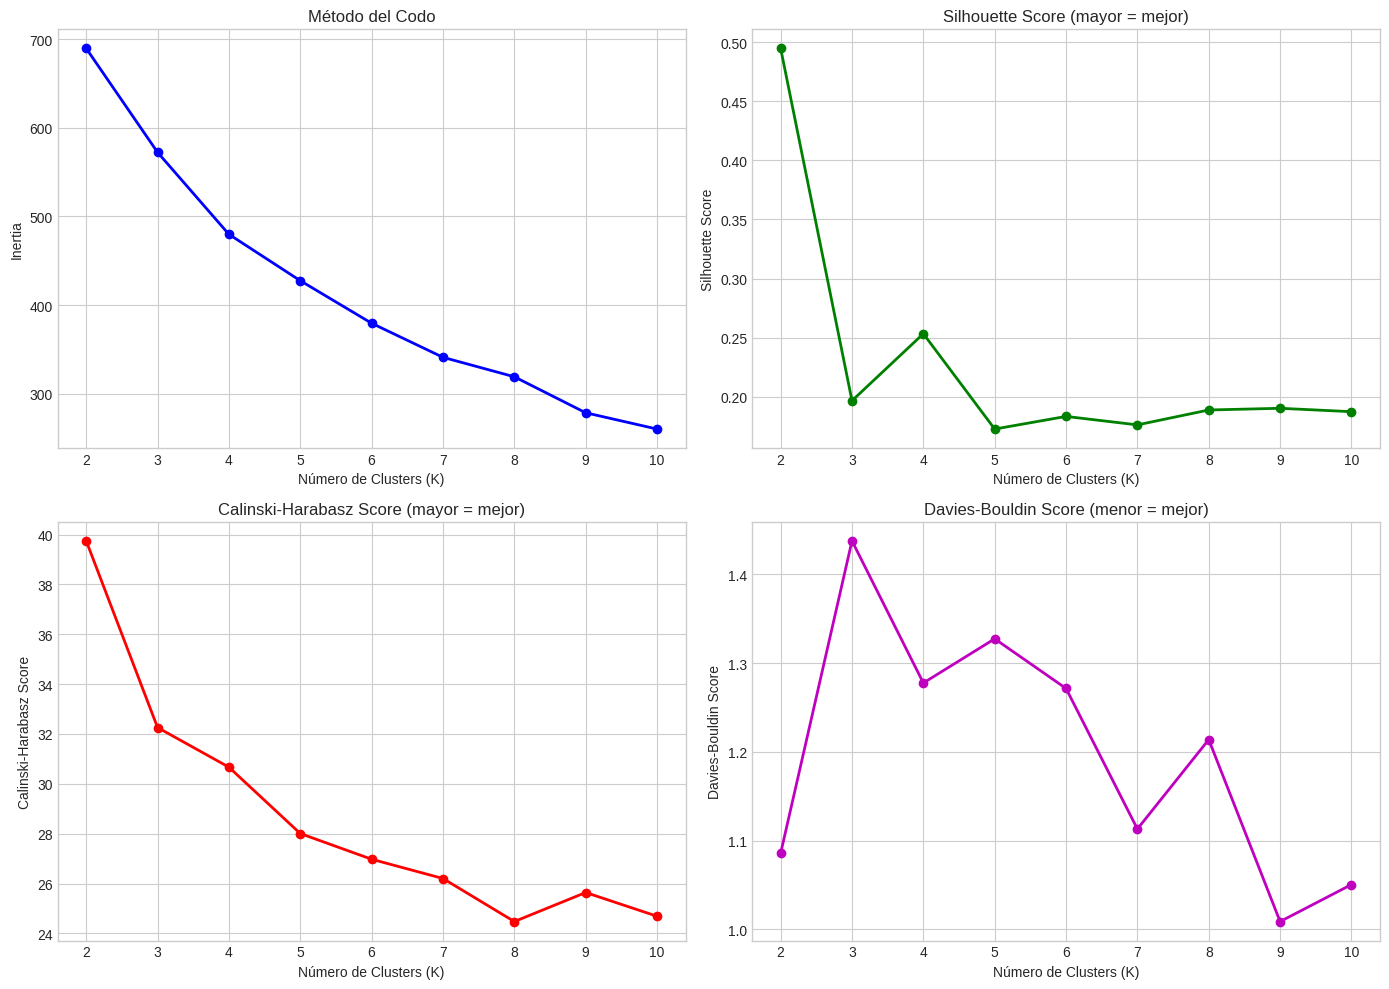


 Resumen de métricas por K:
 K    Inertia  Silhouette  Calinski-Harabasz  Davies-Bouldin
 2 689.472824    0.494638          39.745403        1.085859
 3 572.303082    0.196771          32.258468        1.437869
 4 479.896481    0.253412          30.668716        1.277738
 5 427.630991    0.172818          28.007341        1.327497
 6 379.662904    0.183497          26.975724        1.271575
 7 341.241963    0.176337          26.203245        1.113221
 8 319.318298    0.188930          24.476798        1.213955
 9 278.760096    0.190372          25.641322        1.008907
10 260.395309    0.187492          24.690325        1.050601

 K óptimo según Silhouette: 2


In [19]:
# 4.1 Método del Codo para determinar K óptimo
print("=" * 70)
print(" MÉTODO DEL CODO - DETERMINACIÓN DE K ÓPTIMO")
print("=" * 70)

K_range = range(2, 11)
inertias = []
silhouettes = []
calinski_scores = []
davies_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
    davies_scores.append(davies_bouldin_score(X_scaled, labels))

# Visualizar
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Codo (Inertia)
axes[0, 0].plot(K_range, inertias, 'bo-', linewidth=2)
axes[0, 0].set_xlabel('Número de Clusters (K)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Método del Codo')
axes[0, 0].grid(True)

# Silhouette
axes[0, 1].plot(K_range, silhouettes, 'go-', linewidth=2)
axes[0, 1].set_xlabel('Número de Clusters (K)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (mayor = mejor)')
axes[0, 1].grid(True)

# Calinski-Harabasz
axes[1, 0].plot(K_range, calinski_scores, 'ro-', linewidth=2)
axes[1, 0].set_xlabel('Número de Clusters (K)')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].set_title('Calinski-Harabasz Score (mayor = mejor)')
axes[1, 0].grid(True)

# Davies-Bouldin
axes[1, 1].plot(K_range, davies_scores, 'mo-', linewidth=2)
axes[1, 1].set_xlabel('Número de Clusters (K)')
axes[1, 1].set_ylabel('Davies-Bouldin Score')
axes[1, 1].set_title('Davies-Bouldin Score (menor = mejor)')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Resumen de métricas
print("\n Resumen de métricas por K:")
metrics_df = pd.DataFrame({
    'K': list(K_range),
    'Inertia': inertias,
    'Silhouette': silhouettes,
    'Calinski-Harabasz': calinski_scores,
    'Davies-Bouldin': davies_scores
})
print(metrics_df.to_string(index=False))

# K óptimo según silhouette
k_optimal = list(K_range)[np.argmax(silhouettes)]
print(f"\n K óptimo según Silhouette: {k_optimal}")

 KMEANS CON K=2

 Distribución de clusters:
cluster_kmeans
0    11
1    76
Name: count, dtype: int64

 Métricas de evaluación:
   Silhouette Score: 0.4946
   Calinski-Harabasz: 39.7454
   Davies-Bouldin: 1.0859


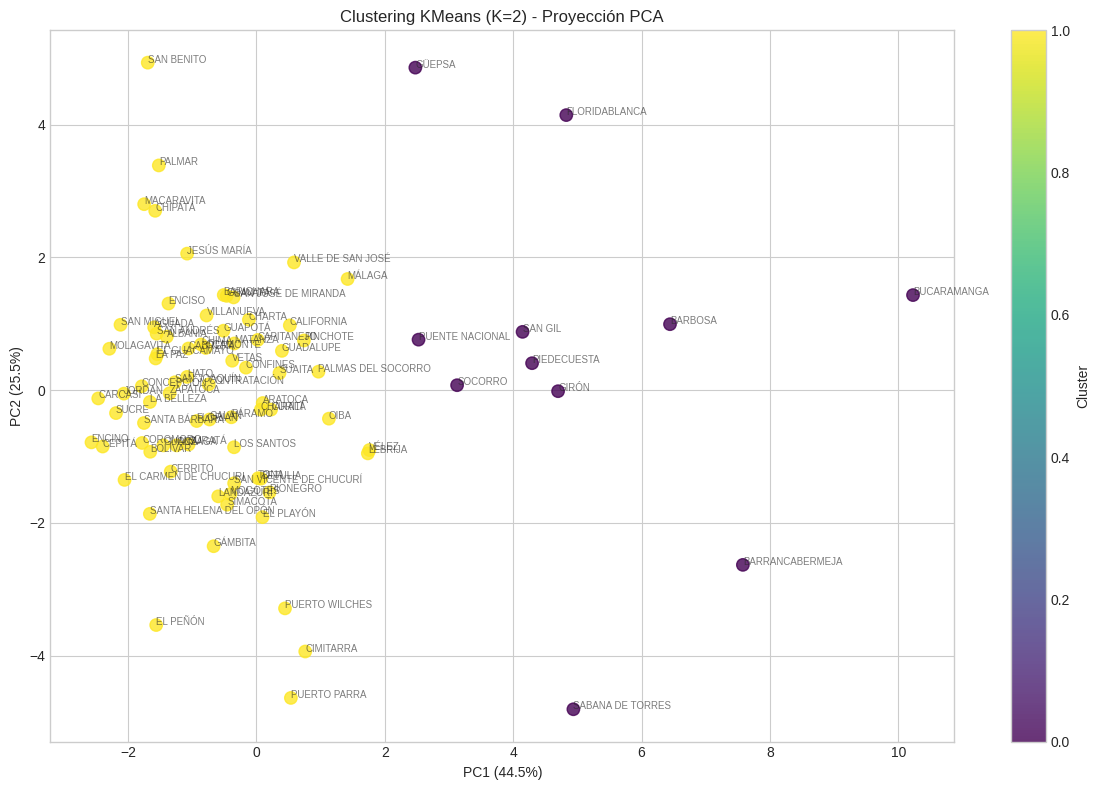

In [20]:
# 4.2 Entrenar KMeans con K óptimo (inicial)
print("=" * 70)
print(f" KMEANS CON K={k_optimal}")
print("=" * 70)

kmeans_base = KMeans(n_clusters=k_optimal, random_state=42, n_init=10, max_iter=300)
df_cluster['cluster_kmeans'] = kmeans_base.fit_predict(X_scaled)

print(f"\n Distribución de clusters:")
print(df_cluster['cluster_kmeans'].value_counts().sort_index())

# Métricas
print(f"\n Métricas de evaluación:")
print(f"   Silhouette Score: {silhouette_score(X_scaled, df_cluster['cluster_kmeans']):.4f}")
print(f"   Calinski-Harabasz: {calinski_harabasz_score(X_scaled, df_cluster['cluster_kmeans']):.4f}")
print(f"   Davies-Bouldin: {davies_bouldin_score(X_scaled, df_cluster['cluster_kmeans']):.4f}")

# Visualización en PCA
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                      c=df_cluster['cluster_kmeans'], 
                      cmap='viridis', alpha=0.8, s=80)
plt.colorbar(scatter, label='Cluster')

# Anotar municipios
for i, mun in enumerate(df_cluster['municipio']):
    plt.annotate(mun, (X_pca[i, 0], X_pca[i, 1]), fontsize=7, alpha=0.6)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title(f'Clustering KMeans (K={k_optimal}) - Proyección PCA')
plt.tight_layout()
plt.show()

 PERFIL DE CADA CLUSTER (KMEANS)

 Perfil promedio de cada cluster:
cluster_kmeans                       0        1
total_delitos_tasa            16422.20  6434.03
HURTOS_tasa                    4141.26   787.34
LESIONES_tasa                  6198.94  2495.66
VIOLENCIA INTRAFAMILIAR_tasa   3010.97  1290.83
HOMICIDIOS_tasa                 343.85   208.53
AMENAZAS_tasa                  1718.43   908.11
log_densidad                      6.28     4.03
log_area                          5.38     5.34
centros_por_km2                   0.03     0.02
proporcion_menores                0.17     0.18
proporcion_adultos                0.77     0.75
proporcion_adolescentes           0.06     0.06


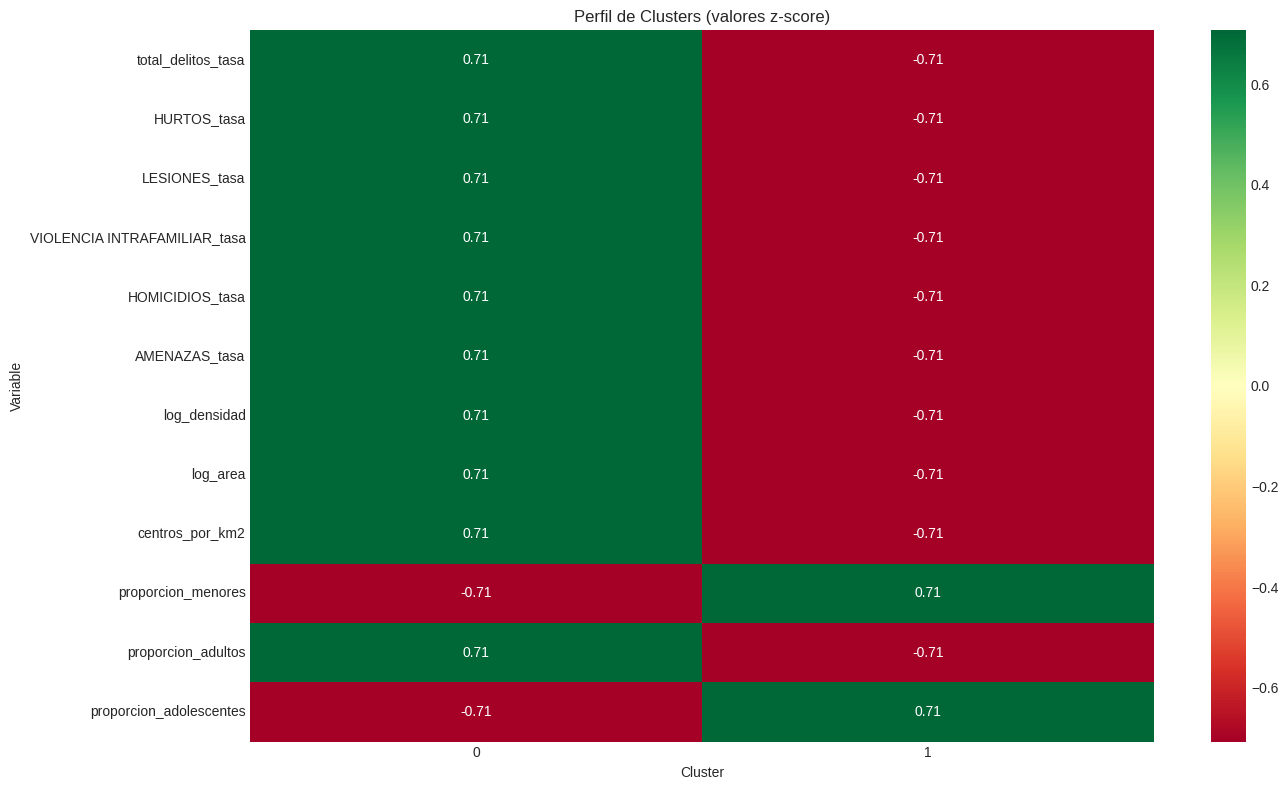

In [21]:
# 4.3 Análisis de características por cluster
print("=" * 70)
print(" PERFIL DE CADA CLUSTER (KMEANS)")
print("=" * 70)

# Estadísticas por cluster
cluster_profile = df_cluster.groupby('cluster_kmeans')[FEATURE_COLS].mean()

print("\n Perfil promedio de cada cluster:")
print(cluster_profile.T.round(2))

# Heatmap del perfil
plt.figure(figsize=(14, 8))
# Normalizar por fila para comparar
cluster_profile_norm = (cluster_profile.T - cluster_profile.T.mean(axis=1).values.reshape(-1, 1)) / cluster_profile.T.std(axis=1).values.reshape(-1, 1)
sns.heatmap(cluster_profile_norm, annot=True, fmt='.2f', cmap='RdYlGn', center=0)
plt.title('Perfil de Clusters (valores z-score)')
plt.xlabel('Cluster')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

---
## 5. Modelado: HDBSCAN (Clustering basado en densidad)

In [22]:
# 5.1 HDBSCAN - Clustering basado en densidad
print("=" * 70)
print(" HDBSCAN - CLUSTERING BASADO EN DENSIDAD")
print("=" * 70)

if HDBSCAN_AVAILABLE:
    # HDBSCAN con parámetros iniciales
    hdb = hdbscan.HDBSCAN(
        min_cluster_size=5,  # Mínimo de puntos para formar cluster
        min_samples=3,       # Mínimo de vecinos
        metric='euclidean',
        cluster_selection_epsilon=0.0,
        cluster_selection_method='eom'  # Excess of Mass
    )
    
    df_cluster['cluster_hdbscan'] = hdb.fit_predict(X_scaled)
    
    print(f"\n🔹 Distribución de clusters HDBSCAN:")
    print(df_cluster['cluster_hdbscan'].value_counts().sort_index())
    print(f"\n🔹 Ruido (cluster -1): {(df_cluster['cluster_hdbscan'] == -1).sum()} municipios")
    
    # Métricas (excluyendo ruido)
    mask_no_noise = df_cluster['cluster_hdbscan'] != -1
    if mask_no_noise.sum() > 1 and df_cluster.loc[mask_no_noise, 'cluster_hdbscan'].nunique() > 1:
        sil = silhouette_score(X_scaled[mask_no_noise], df_cluster.loc[mask_no_noise, 'cluster_hdbscan'])
        print(f"\n🔹 Silhouette Score (sin ruido): {sil:.4f}")
    
    # Visualización
    plt.figure(figsize=(12, 8))
    colors = df_cluster['cluster_hdbscan'].map(lambda x: 'gray' if x == -1 else plt.cm.viridis(x / max(1, df_cluster['cluster_hdbscan'].max())))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.8, s=80)
    
    for i, mun in enumerate(df_cluster['municipio']):
        plt.annotate(mun, (X_pca[i, 0], X_pca[i, 1]), fontsize=7, alpha=0.6)
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.title('Clustering HDBSCAN - Proyección PCA (gris = ruido)')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ HDBSCAN no está instalado. Ejecutar: pip install hdbscan")
    df_cluster['cluster_hdbscan'] = -1

 HDBSCAN - CLUSTERING BASADO EN DENSIDAD
⚠️ HDBSCAN no está instalado. Ejecutar: pip install hdbscan


---
## 6. Optimización de Hiperparámetros

In [23]:
# 6.1 Optimización de KMeans
print("=" * 70)
print(" OPTIMIZACIÓN DE HIPERPARÁMETROS - KMEANS")
print("=" * 70)

# Grid de hiperparámetros
k_values = [3, 4, 5, 6, 7, 8]
init_methods = ['k-means++', 'random']
n_init_values = [10, 20, 30]

results_kmeans = []

for k in k_values:
    for init in init_methods:
        for n_init in n_init_values:
            kmeans = KMeans(n_clusters=k, init=init, n_init=n_init, 
                           random_state=42, max_iter=300)
            labels = kmeans.fit_predict(X_scaled)
            
            sil = silhouette_score(X_scaled, labels)
            cal = calinski_harabasz_score(X_scaled, labels)
            dav = davies_bouldin_score(X_scaled, labels)
            
            results_kmeans.append({
                'k': k,
                'init': init,
                'n_init': n_init,
                'silhouette': sil,
                'calinski': cal,
                'davies_bouldin': dav,
                'inertia': kmeans.inertia_
            })

results_kmeans_df = pd.DataFrame(results_kmeans)

print("\n🔹 Top 10 configuraciones por Silhouette Score:")
print(results_kmeans_df.nlargest(10, 'silhouette').to_string(index=False))

# Mejor configuración
best_kmeans_config = results_kmeans_df.loc[results_kmeans_df['silhouette'].idxmax()]
print(f"\n MEJOR CONFIGURACIÓN KMEANS:")
print(f"   K: {int(best_kmeans_config['k'])}")
print(f"   Init: {best_kmeans_config['init']}")
print(f"   N_init: {int(best_kmeans_config['n_init'])}")
print(f"   Silhouette: {best_kmeans_config['silhouette']:.4f}")

 OPTIMIZACIÓN DE HIPERPARÁMETROS - KMEANS

🔹 Top 10 configuraciones por Silhouette Score:
 k      init  n_init  silhouette  calinski  davies_bouldin    inertia
 4    random      10    0.280548 30.686069        1.183833 479.753769
 3    random      10    0.268695 32.127641        1.282931 573.313134
 4    random      30    0.266388 31.102693        1.226385 476.352727
 5 k-means++      30    0.255511 28.267698        1.171687 425.347991
 5    random      20    0.255511 28.267698        1.171687 425.347991
 5    random      30    0.255511 28.267698        1.171687 425.347991
 4 k-means++      10    0.253412 30.668716        1.277738 479.896481
 4 k-means++      20    0.248388 30.774613        1.259654 479.026897
 4 k-means++      30    0.248388 30.774613        1.259654 479.026897
 4    random      20    0.248388 30.774613        1.259654 479.026897

 MEJOR CONFIGURACIÓN KMEANS:
   K: 4
   Init: random
   N_init: 10
   Silhouette: 0.2805

🔹 Top 10 configuraciones por Silhouette Score:
 k

In [24]:
# 6.2 Optimización de HDBSCAN
print("=" * 70)
print(" OPTIMIZACIÓN DE HIPERPARÁMETROS - HDBSCAN")
print("=" * 70)

if HDBSCAN_AVAILABLE:
    min_cluster_sizes = [3, 5, 7, 10]
    min_samples_values = [2, 3, 5, 7]
    
    results_hdbscan = []
    
    for min_cluster in min_cluster_sizes:
        for min_samp in min_samples_values:
            try:
                hdb = hdbscan.HDBSCAN(
                    min_cluster_size=min_cluster,
                    min_samples=min_samp,
                    metric='euclidean',
                    cluster_selection_method='eom'
                )
                labels = hdb.fit_predict(X_scaled)
                
                # Excluir ruido para métricas
                mask = labels != -1
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                n_noise = (labels == -1).sum()
                
                if mask.sum() > 1 and len(set(labels[mask])) > 1:
                    sil = silhouette_score(X_scaled[mask], labels[mask])
                else:
                    sil = -1
                
                results_hdbscan.append({
                    'min_cluster_size': min_cluster,
                    'min_samples': min_samp,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'pct_noise': n_noise / len(labels) * 100,
                    'silhouette': sil
                })
            except Exception as e:
                continue
    
    results_hdbscan_df = pd.DataFrame(results_hdbscan)
    
    print("\n🔹 Resultados de optimización HDBSCAN:")
    print(results_hdbscan_df.to_string(index=False))
    
    # Mejor configuración (silhouette > 0 y menos ruido)
    valid_configs = results_hdbscan_df[results_hdbscan_df['silhouette'] > 0]
    if len(valid_configs) > 0:
        best_hdbscan_config = valid_configs.loc[valid_configs['silhouette'].idxmax()]
        print(f"\n🏆 MEJOR CONFIGURACIÓN HDBSCAN:")
        print(f"   min_cluster_size: {int(best_hdbscan_config['min_cluster_size'])}")
        print(f"   min_samples: {int(best_hdbscan_config['min_samples'])}")
        print(f"   N clusters: {int(best_hdbscan_config['n_clusters'])}")
        print(f"   % Ruido: {best_hdbscan_config['pct_noise']:.1f}%")
        print(f"   Silhouette: {best_hdbscan_config['silhouette']:.4f}")
    else:
        print("⚠️ No se encontró configuración válida de HDBSCAN")
        best_hdbscan_config = None
else:
    print("⚠️ HDBSCAN no está instalado")
    results_hdbscan_df = pd.DataFrame()
    best_hdbscan_config = None

 OPTIMIZACIÓN DE HIPERPARÁMETROS - HDBSCAN
⚠️ HDBSCAN no está instalado


---
## 7. Modelo Óptimo Final

In [25]:
# 7.1 Entrenar modelo óptimo
print("=" * 70)
print(" ENTRENAMIENTO DEL MODELO ÓPTIMO (KMEANS)")
print("=" * 70)

# Usar la mejor configuración de KMeans
BEST_K = int(best_kmeans_config['k'])
BEST_INIT = best_kmeans_config['init']
BEST_N_INIT = int(best_kmeans_config['n_init'])

kmeans_optimal = KMeans(
    n_clusters=BEST_K,
    init=BEST_INIT,
    n_init=BEST_N_INIT,
    random_state=42,
    max_iter=500
)

df_cluster['cluster_final'] = kmeans_optimal.fit_predict(X_scaled)

print(f"\n Configuración final:")
print(f"   K: {BEST_K}")
print(f"   Init: {BEST_INIT}")
print(f"   N_init: {BEST_N_INIT}")

print(f"\n Distribución de clusters:")
cluster_dist = df_cluster['cluster_final'].value_counts().sort_index()
print(cluster_dist)

# Métricas finales
final_silhouette = silhouette_score(X_scaled, df_cluster['cluster_final'])
final_calinski = calinski_harabasz_score(X_scaled, df_cluster['cluster_final'])
final_davies = davies_bouldin_score(X_scaled, df_cluster['cluster_final'])

print(f"\n Métricas del modelo final:")
print(f"   Silhouette Score: {final_silhouette:.4f}")
print(f"   Calinski-Harabasz: {final_calinski:.4f}")
print(f"   Davies-Bouldin: {final_davies:.4f}")

 ENTRENAMIENTO DEL MODELO ÓPTIMO (KMEANS)

 Configuración final:
   K: 4
   Init: random
   N_init: 10

 Distribución de clusters:
cluster_final
0    55
1    17
2     9
3     6
Name: count, dtype: int64

 Métricas del modelo final:
   Silhouette Score: 0.2805
   Calinski-Harabasz: 30.6861
   Davies-Bouldin: 1.1838


In [26]:
# 7.2 Perfil detallado de cada cluster
print("=" * 70)
print(" PERFIL DETALLADO DE CADA CLUSTER")
print("=" * 70)

# Estadísticas por cluster
cluster_profiles = []
for cluster_id in sorted(df_cluster['cluster_final'].unique()):
    df_c = df_cluster[df_cluster['cluster_final'] == cluster_id]
    
    profile = {
        'cluster': cluster_id,
        'n_municipios': len(df_c),
        'municipios': ', '.join(df_c['municipio'].tolist()[:5]) + ('...' if len(df_c) > 5 else ''),
        # Delitos
        'total_delitos_prom': df_c['total_delitos'].mean(),
        'tasa_delitos_100k': df_c['total_delitos_tasa'].mean(),
        # Geografía
        'densidad_prom': df_c['densidad_poblacional'].mean() if 'densidad_poblacional' in df_c.columns else np.exp(df_c['log_densidad'].mean()),
        'area_prom': df_c['area_km2'].mean() if 'area_km2' in df_c.columns else np.exp(df_c['log_area'].mean()),
        # Población
        'poblacion_prom': df_c['poblacion_total'].mean(),
        # Proporciones
        'prop_menores': df_c['proporcion_menores'].mean(),
        'prop_adultos': df_c['proporcion_adultos'].mean()
    }
    cluster_profiles.append(profile)

profiles_df = pd.DataFrame(cluster_profiles)
print(profiles_df.to_string(index=False))

# Descripción cualitativa de clusters
print("\n" + "=" * 70)
print(" DESCRIPCIÓN CUALITATIVA DE CLUSTERS")
print("=" * 70)

for i, row in profiles_df.iterrows():
    print(f"\n🔷 CLUSTER {int(row['cluster'])} ({int(row['n_municipios'])} municipios)")
    print(f"   Municipios: {row['municipios']}")
    
    # Clasificación automática
    if row['tasa_delitos_100k'] > profiles_df['tasa_delitos_100k'].median() * 1.5:
        tipo_delito = "ALTA tasa de delitos"
    elif row['tasa_delitos_100k'] < profiles_df['tasa_delitos_100k'].median() * 0.5:
        tipo_delito = "BAJA tasa de delitos"
    else:
        tipo_delito = "MEDIA tasa de delitos"
    
    if row['densidad_prom'] > profiles_df['densidad_prom'].median():
        tipo_zona = "URBANO/SEMI-URBANO"
    else:
        tipo_zona = "RURAL"
    
    print(f"   Tipo: {tipo_zona} con {tipo_delito}")

 PERFIL DETALLADO DE CADA CLUSTER
 cluster  n_municipios                                                     municipios  total_delitos_prom  tasa_delitos_100k  densidad_prom  area_prom  poblacion_prom  prop_menores  prop_adultos
       0            55                AGUADA, ALBANIA, ARATOCA, BARICHARA, BOLÍVAR...          579.363636        5874.976189      74.365262 239.489361     9378.331614      0.178909      0.760559
       1            17            BETULIA, CIMITARRA, EL PEÑÓN, EL PLAYÓN, GÁMBITA...         2596.470588        9607.104939      44.421916 816.250752    24442.343445      0.203466      0.730159
       2             9 BUCARAMANGA, BARBOSA, BARRANCABERMEJA, FLORIDABLANCA, GIRÓN...        44885.444444       16322.105034    1765.110497 347.858941   249208.770760      0.164499      0.774945
       3             6         GÜEPSA, JESÚS MARÍA, MACARAVITA, PALMAR, SAN BENITO...          371.000000        6047.799468     160.264346  63.764957     5515.316049      0.168831      

 VISUALIZACIÓN DEL MODELO ÓPTIMO


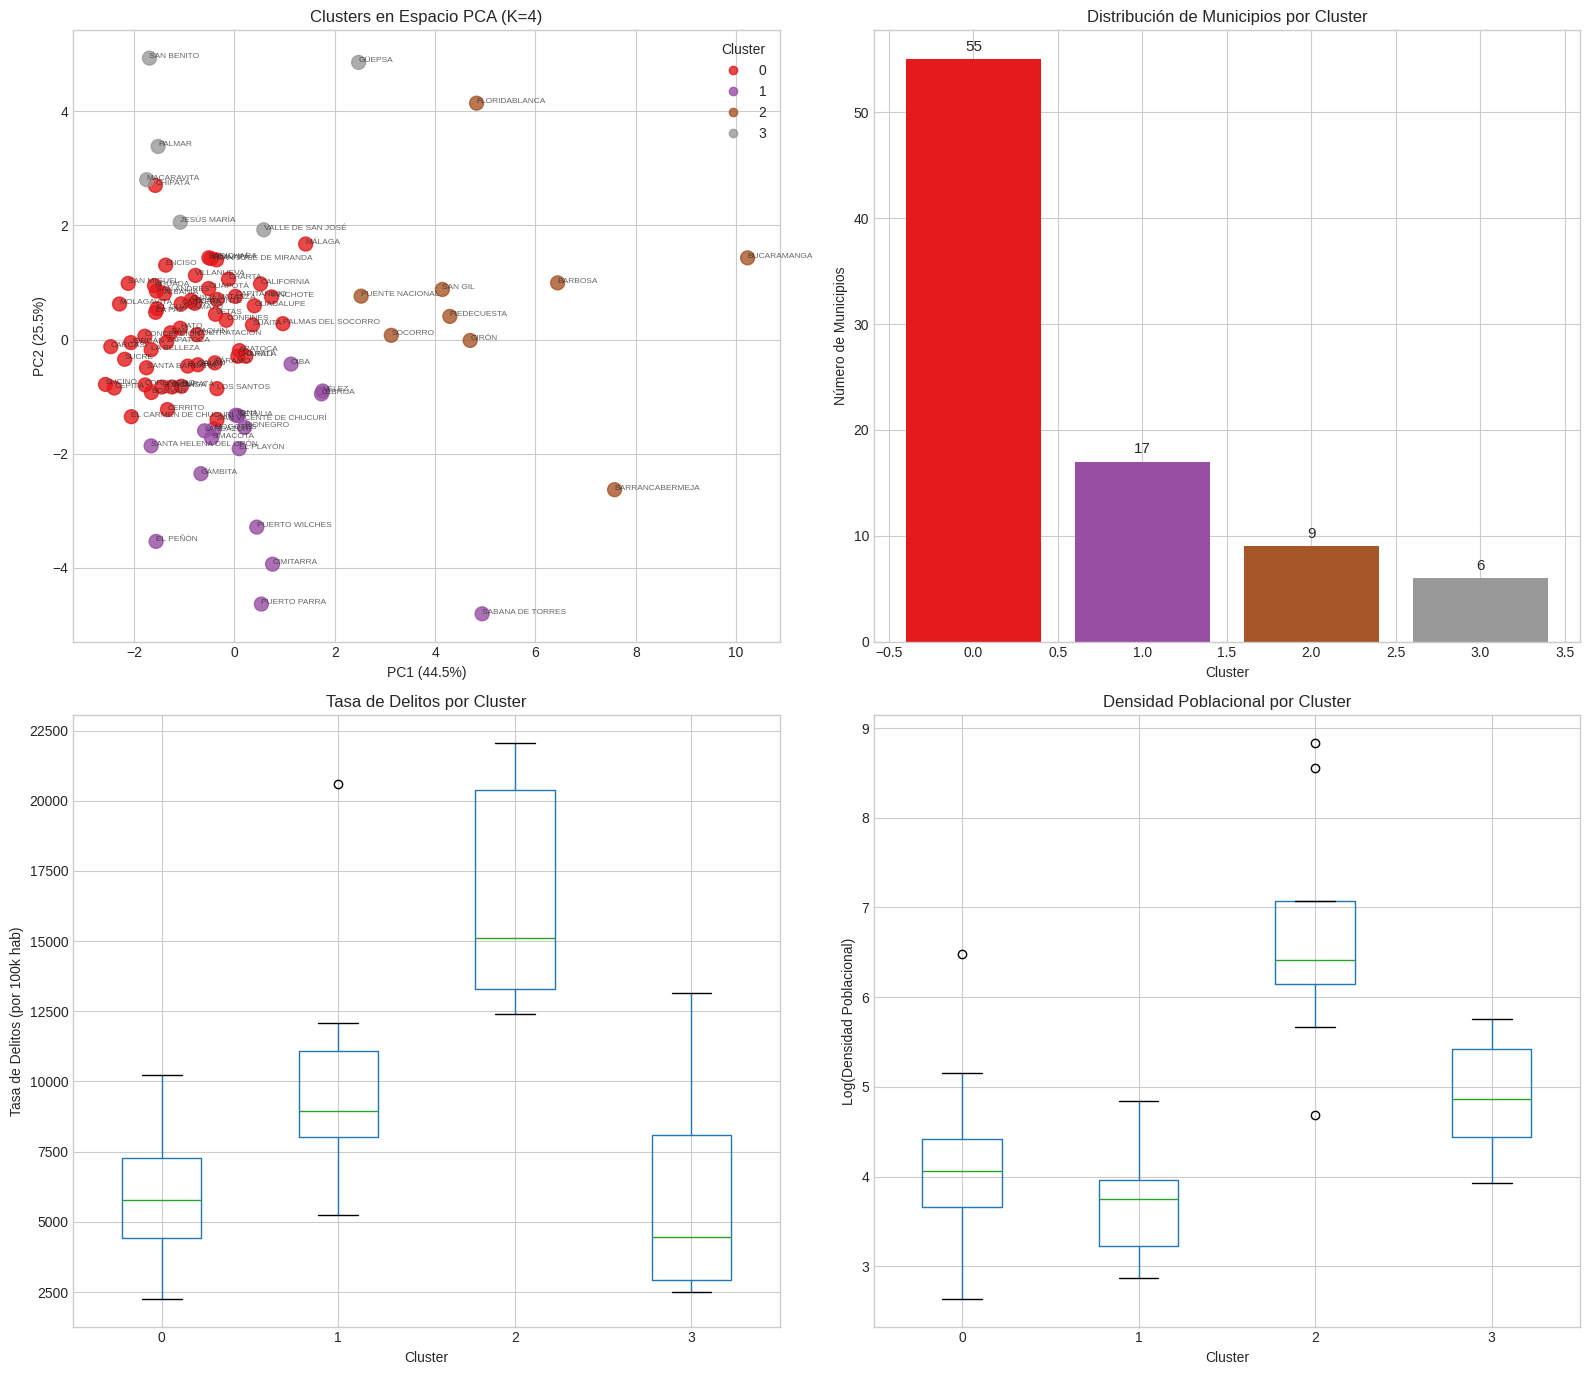

In [27]:
# 7.3 Visualización del modelo óptimo
print("=" * 70)
print(" VISUALIZACIÓN DEL MODELO ÓPTIMO")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. PCA con clusters
ax1 = axes[0, 0]
scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], 
                      c=df_cluster['cluster_final'], 
                      cmap='Set1', alpha=0.8, s=100)
for i, mun in enumerate(df_cluster['municipio']):
    ax1.annotate(mun, (X_pca[i, 0], X_pca[i, 1]), fontsize=6, alpha=0.7)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax1.set_title(f'Clusters en Espacio PCA (K={BEST_K})')
ax1.legend(*scatter.legend_elements(), title="Cluster")

# 2. Distribución de clusters
ax2 = axes[0, 1]
cluster_counts = df_cluster['cluster_final'].value_counts().sort_index()
bars = ax2.bar(cluster_counts.index, cluster_counts.values, color=plt.cm.Set1(np.linspace(0, 1, BEST_K)))
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Número de Municipios')
ax2.set_title('Distribución de Municipios por Cluster')
for bar, val in zip(bars, cluster_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(val), 
             ha='center', va='bottom', fontsize=11)

# 3. Boxplot de tasa de delitos por cluster
ax3 = axes[1, 0]
df_cluster.boxplot(column='total_delitos_tasa', by='cluster_final', ax=ax3)
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Tasa de Delitos (por 100k hab)')
ax3.set_title('Tasa de Delitos por Cluster')
plt.suptitle('')

# 4. Boxplot de densidad por cluster
ax4 = axes[1, 1]
df_cluster.boxplot(column='log_densidad', by='cluster_final', ax=ax4)
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Log(Densidad Poblacional)')
ax4.set_title('Densidad Poblacional por Cluster')
plt.suptitle('')

plt.tight_layout()
plt.show()

 RADAR CHART DE PERFILES DE CLUSTER


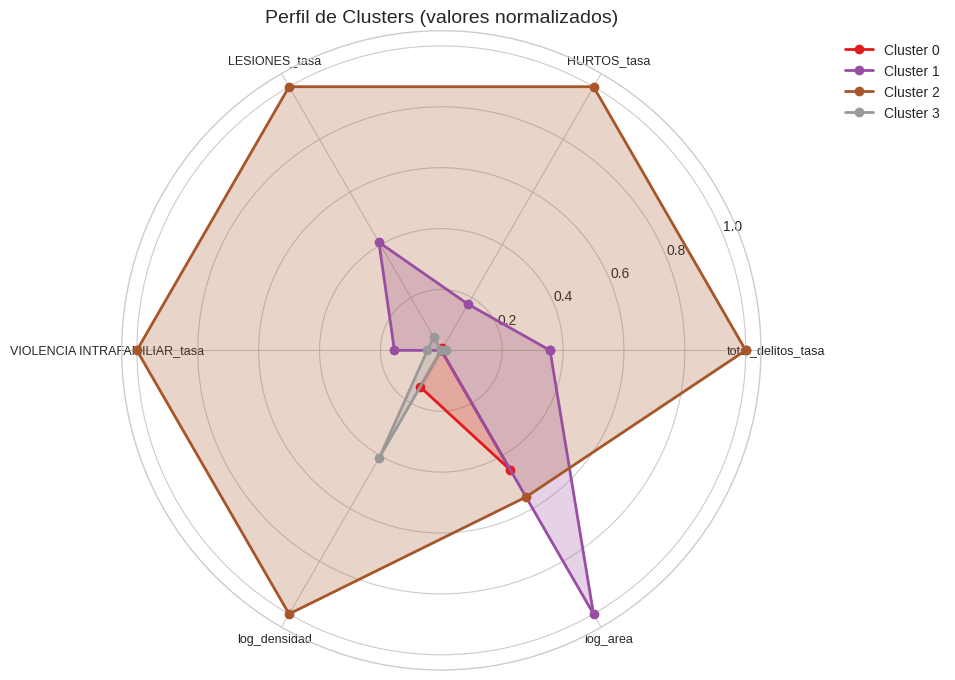

In [28]:
# 7.4 Radar chart de perfiles de cluster
print("=" * 70)
print(" RADAR CHART DE PERFILES DE CLUSTER")
print("=" * 70)

# Variables para radar
radar_cols = ['total_delitos_tasa', 'HURTOS_tasa', 'LESIONES_tasa', 
              'VIOLENCIA INTRAFAMILIAR_tasa', 'log_densidad', 'log_area']

# Normalizar para radar (0-1)
cluster_means = df_cluster.groupby('cluster_final')[radar_cols].mean()
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# Crear radar
angles = np.linspace(0, 2 * np.pi, len(radar_cols), endpoint=False).tolist()
angles += angles[:1]  # Cerrar el círculo

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

colors = plt.cm.Set1(np.linspace(0, 1, BEST_K))

for idx, (cluster_id, values) in enumerate(cluster_means_norm.iterrows()):
    values_list = values.tolist()
    values_list += values_list[:1]
    ax.plot(angles, values_list, 'o-', linewidth=2, label=f'Cluster {cluster_id}', color=colors[idx])
    ax.fill(angles, values_list, alpha=0.25, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_cols, size=9)
ax.set_title('Perfil de Clusters (valores normalizados)', size=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

---
## 8. Guardar Modelo y Resultados

In [29]:
# 8.1 Guardar modelo y artefactos
print("=" * 70)
print(" GUARDANDO MODELO Y ARTEFACTOS")
print("=" * 70)

# 1. Modelo KMeans
joblib.dump(kmeans_optimal, OUTPUT_DIR / 'kmeans_geo_municipal.joblib')
print(f"✅ Modelo guardado: kmeans_geo_municipal.joblib")

# 2. Scaler
joblib.dump(scaler, OUTPUT_DIR / 'scaler.joblib')
print(f"✅ Scaler guardado: scaler.joblib")

# 3. PCA (para visualización)
joblib.dump(pca, OUTPUT_DIR / 'pca_2d.joblib')
print(f"✅ PCA guardado: pca_2d.joblib")

# 4. Metadata
metadata = {
    'fecha_entrenamiento': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'algoritmo': 'KMeans',
    'n_clusters': BEST_K,
    'parametros': {
        'init': BEST_INIT,
        'n_init': BEST_N_INIT,
        'max_iter': 500,
        'random_state': 42
    },
    'features': FEATURE_COLS,
    'metricas': {
        'silhouette_score': float(final_silhouette),
        'calinski_harabasz': float(final_calinski),
        'davies_bouldin': float(final_davies)
    },
    'n_municipios': len(df_cluster),
    'distribucion_clusters': cluster_dist.to_dict()
}

with open(OUTPUT_DIR / 'metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)
print(f"✅ Metadata guardado: metadata.json")

# 5. Dataset de municipios con clusters
df_cluster_export = df_cluster[['codigo_municipio', 'municipio', 'cluster_final'] + FEATURE_COLS].copy()
df_cluster_export.to_parquet(OUTPUT_DIR / 'municipios_clusters.parquet')
print(f"✅ Dataset guardado: municipios_clusters.parquet")

# 6. También en CSV para fácil visualización
df_cluster_export.to_csv(OUTPUT_DIR / 'municipios_clusters.csv', index=False)
print(f"✅ Dataset guardado: municipios_clusters.csv")

print(f"\n Archivos guardados en: {OUTPUT_DIR}")

 GUARDANDO MODELO Y ARTEFACTOS
✅ Modelo guardado: kmeans_geo_municipal.joblib
✅ Scaler guardado: scaler.joblib
✅ PCA guardado: pca_2d.joblib
✅ Metadata guardado: metadata.json
✅ Dataset guardado: municipios_clusters.parquet
✅ Dataset guardado: municipios_clusters.csv

 Archivos guardados en: /home/byverbel/challenges/Datos-al-Ecosistema/models/clustering/geo_municipal


In [30]:
# 8.2 Guardar resultados descriptivos para chatbot/tablero
print("=" * 70)
print(" GUARDANDO RESULTADOS DESCRIPTIVOS")
print("=" * 70)

# Crear directorio descriptivo
DESC_DIR = BASE_DIR / 'models' / 'descriptivo' / 'clustering_geo'
DESC_DIR.mkdir(parents=True, exist_ok=True)

# 1. Perfiles de clusters
perfiles_clusters = {}
for cluster_id in sorted(df_cluster['cluster_final'].unique()):
    df_c = df_cluster[df_cluster['cluster_final'] == cluster_id]
    
    perfiles_clusters[int(cluster_id)] = {
        'n_municipios': int(len(df_c)),
        'municipios': df_c['municipio'].tolist(),
        'codigos': df_c['codigo_municipio'].astype(int).tolist(),
        'estadisticas': {
            'tasa_delitos_promedio': round(df_c['total_delitos_tasa'].mean(), 2),
            'densidad_promedio': round(df_c['log_densidad'].apply(np.exp).mean(), 2),
            'poblacion_promedio': round(df_c['poblacion_total'].mean(), 0),
            'area_promedio_km2': round(df_c['log_area'].apply(np.exp).mean(), 2)
        }
    }

with open(DESC_DIR / 'perfiles_clusters.json', 'w', encoding='utf-8') as f:
    json.dump(perfiles_clusters, f, indent=2, ensure_ascii=False)
print(f"✅ Perfiles guardados: perfiles_clusters.json")

# 2. Asignación de clusters por municipio
asignacion = {}
for _, row in df_cluster.iterrows():
    asignacion[int(row['codigo_municipio'])] = {
        'municipio': row['municipio'],
        'cluster': int(row['cluster_final']),
        'tasa_delitos': round(row['total_delitos_tasa'], 2),
        'densidad': round(np.exp(row['log_densidad']), 2)
    }

with open(DESC_DIR / 'asignacion_municipios.json', 'w', encoding='utf-8') as f:
    json.dump(asignacion, f, indent=2, ensure_ascii=False)
print(f"✅ Asignación guardada: asignacion_municipios.json")

# 3. Respuestas para chatbot
respuestas_chatbot = {
    'pregunta_cluster_municipio': 'Usa asignacion_municipios.json con el código del municipio',
    'pregunta_municipios_similares': 'Busca en perfiles_clusters.json el cluster del municipio y retorna los demás',
    'pregunta_cluster_mas_peligroso': {
        'cluster': int(df_cluster.groupby('cluster_final')['total_delitos_tasa'].mean().idxmax()),
        'tasa_promedio': round(df_cluster.groupby('cluster_final')['total_delitos_tasa'].mean().max(), 2)
    },
    'pregunta_cluster_mas_seguro': {
        'cluster': int(df_cluster.groupby('cluster_final')['total_delitos_tasa'].mean().idxmin()),
        'tasa_promedio': round(df_cluster.groupby('cluster_final')['total_delitos_tasa'].mean().min(), 2)
    }
}

with open(DESC_DIR / 'respuestas_chatbot.json', 'w', encoding='utf-8') as f:
    json.dump(respuestas_chatbot, f, indent=2, ensure_ascii=False)
print(f"✅ Respuestas chatbot guardadas: respuestas_chatbot.json")

print(f"\n Archivos descriptivos en: {DESC_DIR}")

 GUARDANDO RESULTADOS DESCRIPTIVOS
✅ Perfiles guardados: perfiles_clusters.json
✅ Asignación guardada: asignacion_municipios.json
✅ Respuestas chatbot guardadas: respuestas_chatbot.json

 Archivos descriptivos en: /home/byverbel/challenges/Datos-al-Ecosistema/models/descriptivo/clustering_geo


---
## 9. Evaluación Final y Resumen

In [31]:
# 9.1 Resumen final
print("=" * 70)
print(" RESUMEN FINAL DEL MODELO DE CLUSTERING")
print("=" * 70)

print(f"""
 MODELO FINAL: KMeans
{"="*50}

 CONFIGURACIÓN:
   • Número de clusters (K): {BEST_K}
   • Método de inicialización: {BEST_INIT}
   • Número de inicializaciones: {BEST_N_INIT}
   • Features utilizadas: {len(FEATURE_COLS)}

 MÉTRICAS DE EVALUACIÓN:
   • Silhouette Score: {final_silhouette:.4f}
     (Rango: -1 a 1, mayor = mejor)
   • Calinski-Harabasz: {final_calinski:.2f}
     (Mayor = mejor)
   • Davies-Bouldin: {final_davies:.4f}
     (Menor = mejor)

 ARCHIVOS GENERADOS:

   Modelo predictivo ({OUTPUT_DIR}):
   ├── kmeans_geo_municipal.joblib  (Modelo KMeans)
   ├── scaler.joblib                (RobustScaler)
   ├── pca_2d.joblib               (PCA para visualización)
   ├── metadata.json               (Configuración)
   ├── municipios_clusters.parquet (Resultados)
   └── municipios_clusters.csv     (Resultados)

   Modelo descriptivo ({DESC_DIR}):
   ├── perfiles_clusters.json      (Estadísticas por cluster)
   ├── asignacion_municipios.json  (Cluster de cada municipio)
   └── respuestas_chatbot.json     (Para chatbot)

 PREGUNTAS QUE RESPONDE:
   1. ¿Qué municipios se parecen entre sí? → perfiles_clusters.json
   2. ¿Qué grupos tienen mayor concentración de delitos? → respuestas_chatbot.json
   3. ¿Existen patrones urbano-rural? → Comparar clusters por densidad
   4. ¿A qué cluster pertenece un municipio? → asignacion_municipios.json

 Modelo de clustering geoespacial-delictivo completado
""")

 RESUMEN FINAL DEL MODELO DE CLUSTERING

 MODELO FINAL: KMeans

 CONFIGURACIÓN:
   • Número de clusters (K): 4
   • Método de inicialización: random
   • Número de inicializaciones: 10
   • Features utilizadas: 12

 MÉTRICAS DE EVALUACIÓN:
   • Silhouette Score: 0.2805
     (Rango: -1 a 1, mayor = mejor)
   • Calinski-Harabasz: 30.69
     (Mayor = mejor)
   • Davies-Bouldin: 1.1838
     (Menor = mejor)

 ARCHIVOS GENERADOS:

   Modelo predictivo (/home/byverbel/challenges/Datos-al-Ecosistema/models/clustering/geo_municipal):
   ├── kmeans_geo_municipal.joblib  (Modelo KMeans)
   ├── scaler.joblib                (RobustScaler)
   ├── pca_2d.joblib               (PCA para visualización)
   ├── metadata.json               (Configuración)
   ├── municipios_clusters.parquet (Resultados)
   └── municipios_clusters.csv     (Resultados)

   Modelo descriptivo (/home/byverbel/challenges/Datos-al-Ecosistema/models/descriptivo/clustering_geo):
   ├── perfiles_clusters.json      (Estadísticas por 

In [32]:
# 9.2 Ejemplo de uso del modelo
print("=" * 70)
print(" EJEMPLO DE USO DEL MODELO")
print("=" * 70)

ejemplo_uso = '''
# =====================================================
# CÓMO USAR EL MODELO EN PRODUCCIÓN
# =====================================================

import joblib
import pandas as pd
import numpy as np

# 1. Cargar modelo y artefactos
model = joblib.load('models/clustering/geo_municipal/kmeans_geo_municipal.joblib')
scaler = joblib.load('models/clustering/geo_municipal/scaler.joblib')

# 2. Preparar datos de un municipio nuevo
nuevo_municipio = {
    'total_delitos_tasa': 150.5,
    'HURTOS_tasa': 45.2,
    'LESIONES_tasa': 30.1,
    'VIOLENCIA INTRAFAMILIAR_tasa': 25.3,
    'HOMICIDIOS_tasa': 5.2,
    'AMENAZAS_tasa': 15.8,
    'log_densidad': np.log(100),  # 100 hab/km2
    'log_area': np.log(500),      # 500 km2
    'centros_por_km2': 0.01,
    'proporcion_menores': 0.20,
    'proporcion_adultos': 0.75,
    'proporcion_adolescentes': 0.05
}

# 3. Escalar y predecir
X_new = pd.DataFrame([nuevo_municipio])
X_new_scaled = scaler.transform(X_new)
cluster_predicho = model.predict(X_new_scaled)[0]

print(f"Cluster asignado: {cluster_predicho}")

# 4. Encontrar municipios similares
import json
with open('models/descriptivo/clustering_geo/perfiles_clusters.json') as f:
    perfiles = json.load(f)

print(f"Municipios similares: {perfiles[str(cluster_predicho)]['municipios']}")
'''

print(ejemplo_uso)

 EJEMPLO DE USO DEL MODELO

# =====================================================
# CÓMO USAR EL MODELO EN PRODUCCIÓN
# =====================================================

import joblib
import pandas as pd
import numpy as np

# 1. Cargar modelo y artefactos
model = joblib.load('models/clustering/geo_municipal/kmeans_geo_municipal.joblib')
scaler = joblib.load('models/clustering/geo_municipal/scaler.joblib')

# 2. Preparar datos de un municipio nuevo
nuevo_municipio = {
    'total_delitos_tasa': 150.5,
    'HURTOS_tasa': 45.2,
    'LESIONES_tasa': 30.1,
    'VIOLENCIA INTRAFAMILIAR_tasa': 25.3,
    'HOMICIDIOS_tasa': 5.2,
    'AMENAZAS_tasa': 15.8,
    'log_densidad': np.log(100),  # 100 hab/km2
    'log_area': np.log(500),      # 500 km2
    'centros_por_km2': 0.01,
    'proporcion_menores': 0.20,
    'proporcion_adultos': 0.75,
    'proporcion_adolescentes': 0.05
}

# 3. Escalar y predecir
X_new = pd.DataFrame([nuevo_municipio])
X_new_scaled = scaler.transform(X_new)
cluster_pred

In [33]:
# 9.3 Tabla final de municipios con sus clusters
print("=" * 70)
print(" TABLA FINAL: MUNICIPIOS Y SUS CLUSTERS")
print("=" * 70)

# Crear tabla resumen
tabla_final = df_cluster[['codigo_municipio', 'municipio', 'cluster_final', 
                          'total_delitos_tasa', 'log_densidad']].copy()
tabla_final.columns = ['Código', 'Municipio', 'Cluster', 'Tasa Delitos', 'Log Densidad']
tabla_final = tabla_final.sort_values(['Cluster', 'Tasa Delitos'], ascending=[True, False])

print(f"\n🔹 Total municipios: {len(tabla_final)}")
print(f"\n{tabla_final.to_string(index=False)}")

 TABLA FINAL: MUNICIPIOS Y SUS CLUSTERS

🔹 Total municipios: 87

 Código              Municipio  Cluster  Tasa Delitos  Log Densidad
  68524     PALMAS DEL SOCORRO        0  10237.920981      4.393755
  68432                 MÁLAGA        0   9848.297107      6.476786
  68132             CALIFORNIA        0   9575.284423      4.440786
  68320              GUADALUPE        0   9117.844753      4.271195
  68770                 SUAITA        0   9006.969122      4.323061
  68051                ARATOCA        0   8698.591467      4.599656
  68167                CHARALÁ        0   8542.530581      3.976035
  68549               PINCHOTE        0   8425.581815      5.156400
  68229                 CURITÍ        0   8340.611603      4.571778
  68147             CAPITANEJO        0   7755.056634      4.930823
  68689 SAN VICENTE DE CHUCURÍ        0   7682.757168      4.124733
  68209               CONFINES        0   7633.195709      4.348151
  68169                 CHARTA        0   7582.6681